In [5]:

import os
import requests
import sys
import gzip

import datetime
import time




import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [6]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

In [22]:
reg = 4
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)



In [8]:
def extract_culumns(df):
    """
    Extracte les colonnes utiles
    "T_moyenne"
    "U_moyenne"
    "FF_moyenne":
    "Rayonnement solaire global (W/m2)" 
    'Nb points soutirage' 
    'Total énergie soutirée (Wh)' 
    }

    Parameters
    ----------
    df : pd.DataFrame ou pd.Series
        Données d'entrée sans index temporel.

    Returns
    -------
    df_out : pd.DataFrame 
        Données avec contenant les colonnes ci-dessus
    """


    columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Nb points soutirage' : 'nb',
    'Total énergie soutirée (Wh)' : 'y'
    }

    df_out = df[columns.keys()]
    df_out = df_out.rename(columns = columns)

    # suppression des na et double s'il en reste
    df_out = df_out.dropna().drop_duplicates()

    return df_out


# Pour régler certaines irrégularité dans les données vues en tant que séries temporelles
def force_datetime_index(df, freq='30min'):
    """
    Force un DataFrame à avoir un DatetimeIndex régulier.

    Parameters
    ----------
    df : pd.DataFrame ou pd.Series
        Données d'entrée sans index temporel.
    freq : str
        Fréquence du pas temporel (ex : '30min', '1H').
    start_time : str or pd.Timestamp
        Date de départ pour créer l'index.

    Returns
    -------
    df_copy : pd.DataFrame or pd.Series
        Données avec un DatetimeIndex régulier.
    """

    date = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))
    start_time = date.min()

    df_copy = df.copy()
    new_index = pd.date_range(start=start_time, periods=len(df_copy), freq=freq)
    df_copy.index = new_index
    return df_copy

def imputer_series(s, method='ffill', window=3):
    """
    Impute les valeurs manquantes d'une série temporelle.

    Parameters
    ----------
    s : pd.Series
        Série temporelle avec un DatetimeIndex.
    method : str
        Méthode d'imputation : 'interpolate', 'ffill', 'bfill', 'rolling'.
    window : int
        Taille de la fenêtre pour la moyenne glissante (si method='rolling').

    Returns
    -------
    s_filled : pd.Series
        Série avec trous imputés.
    """
    s = s.sort_index()

    if method == 'ffill':
        return s.ffill()
    elif method == 'bfill':
        return s.bfill()
    elif method == 'rolling':
        return s.rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    else:
        raise ValueError("Méthode d'imputation non reconnue : utilisez 'interpolate', 'ffill', 'bfill' ou 'rolling'.")


In [23]:
import gc
# Libération


df_1 = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
df_2 = force_datetime_index(df_1, freq='30min')
df_3 = imputer_series(df_2, method='ffill', window=3)
sub_df =  extract_culumns(df_3) 
sub_df.head()

del df_1, df_2, df_3
gc.collect()

D:\Temp\ipykernel_1684\1533284345.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))


794

In [50]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# --------------------------
# Normalisation des données (X seulement)
# --------------------------
class NormalisationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_target = 'y'):
        self.scaler = StandardScaler()
        self.column_target = column_target

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_scaled = pd.DataFrame(self.scaler.transform(X_copy), columns = X_copy.columns)
        X_scaled.rename(columns = {self.column_target : f"{self.column_target}_scaled"}, inplace = True)
        X_scaled[self.column_target] = X_copy[self.column_target].values
        return X_scaled
    
scaler = NormalisationTransformer(column_target = 'y')
scaler.fit(sub_df)
df_sacled = scaler.transform(sub_df)
df_sacled.head()

,T,U,FF,R,nb,y_scaled,y
0,0.187785,-0.712446,1.769085,-0.725511,-1.721321,-0.293151,32457452.0
1,0.187785,-0.712446,1.769085,-0.725511,-1.721321,-0.222859,33427025.0
2,0.166659,-0.707202,1.740529,-0.725511,-1.721321,-0.419096,30720205.0
3,0.166659,-0.707202,1.740529,-0.725511,-1.721321,-0.352019,31645442.0
4,0.154264,-0.673641,1.767115,-0.725511,-1.721321,-0.480017,29879884.0


In [227]:
#Analyse de la consommation en tant que série temporelle 
sub_df = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
valeurs = sub_df['Total énergie soutirée (Wh)'] / sub_df['Nb points soutirage']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d = {'date': date, 'consommation': valeurs}


serie = pd.DataFrame(d)
serie.set_index('date', inplace=True)
start_time = serie.index.min()
serie.index = ((serie.index - start_time).total_seconds() / 1800).astype(int)



#Analyse de la température moyenne en tant que série temporelle 
valeurs_T = sub_df['T_moyenne']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d_T = {'date': date, 'T_moyenne': valeurs_T}


serie_T = pd.DataFrame(d_T)
serie_T.set_index('date', inplace=True)
start_time = serie_T.index.min()
serie_T.index = ((serie_T.index - start_time).total_seconds() / 1800).astype(int)

print(date.min())

D:\Temp\ipykernel_19632\320708917.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
D:\Temp\ipykernel_19632\320708917.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))


2023-01-01 00:00:00


Premier modèle  : SARIMAX (2,1,1)(2,1,0,48) sans variable exogènes
MAP ~ 14%
 

In [7]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 28*48
test_long = 48
serie_log_np = serie #['consommation']

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]
test = serie_annee.iloc[-test_long:]


In [6]:
# Recherche du meilleur modèle
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=1, m=48, max_P =2, max_Q =0,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)



sarima_conso.summary()

c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[48] intercept   : AIC=11868.227, Time=3.20 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[48] intercept   : AIC=12417.512, Time=1.11 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[48] intercept   : AIC=11978.925, Time=4.14 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[48] intercept   : AIC=12224.073, Time=2.10 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[48]             : AIC=12415.513, Time=0.77 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[48] intercept   : AIC=11864.224, Time=13.63 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[48] intercept   : AIC=11522.627, Time=45.28 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[48] intercept   : AIC=11815.657, Time=25.96 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[48] intercept   : AIC=inf, Time=22.80 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[48] intercept   : AIC=11163.704, Time=49.72 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[48] intercept   : AIC=11455.642, Time=17.76 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[48] intercept   : AIC=inf, Time=37.46 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[48]             : AIC=11161.704, Time=20.84 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[48]             : AIC=11453.642, Time=8.55 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[48]             : AIC=11520.628, Time=17.48 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[48]             : AIC=inf, Time=15.84 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[48]             : AIC=inf, Time=11.31 sec

Best model:  ARIMA(2,1,1)(2,1,0)[48]          
Total fit time: 297.977 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1296
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 48)   Log Likelihood               -5574.852
Date:                             Wed, 07 May 2025   AIC                          11161.704
Time:                                     23:44:06   BIC                          11192.475
Sample:                                          0   HQIC                         11173.273
                                            - 1296                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0327      0.060     -0.543      0.587      -0.151       0.085
ar.L2          0.7030      0.030     23.781      0.000       0.645       0.761
ma.L1         -0.3022      0.081     -3.724      0.000      -0.461      -0.143
ar.S.L48      -0.3487      0.031    -11.267      0.000      -0.409      -0.288
ar.S.L96      -0.4738      0.028    -17.034      0.000      -0.528      -0.419
sigma2       437.2379     16.382     26.691      0.000     405.130     469.345
===================================================================================
Ljung-Box (L1) (Q):                  23.22   Jarque-Bera (JB):               848.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
from statsmodels.tsa.statespace import sarimax

sarima_conso = SARIMAX(train['consommation'],order=(2,1,1),
                      seasonal_order=(2,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()

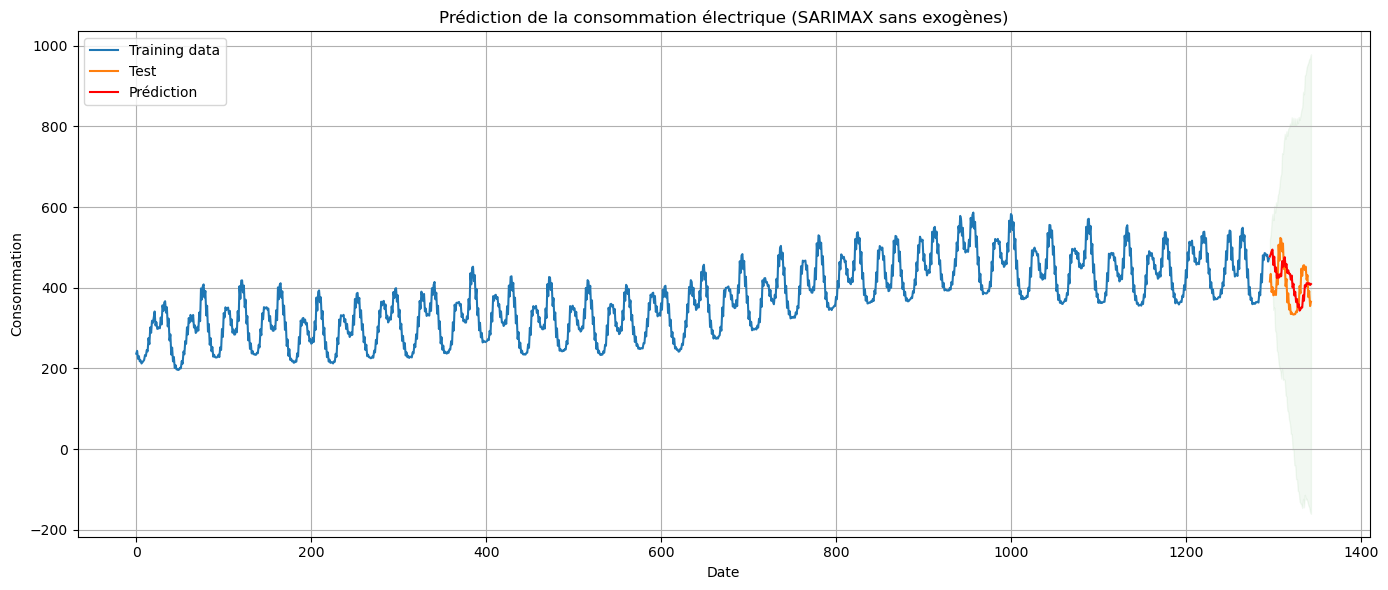

In [8]:
test = serie_annee.iloc[-test_long:]
forecast = results.get_forecast(steps=len(test))
prediction = pd.DataFrame(prediction, index=test.index)
conf_int = forecast.conf_int()


plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prédiction', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='g', alpha=0.05)
plt.title("Prédiction de la consommation électrique (SARIMAX sans exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

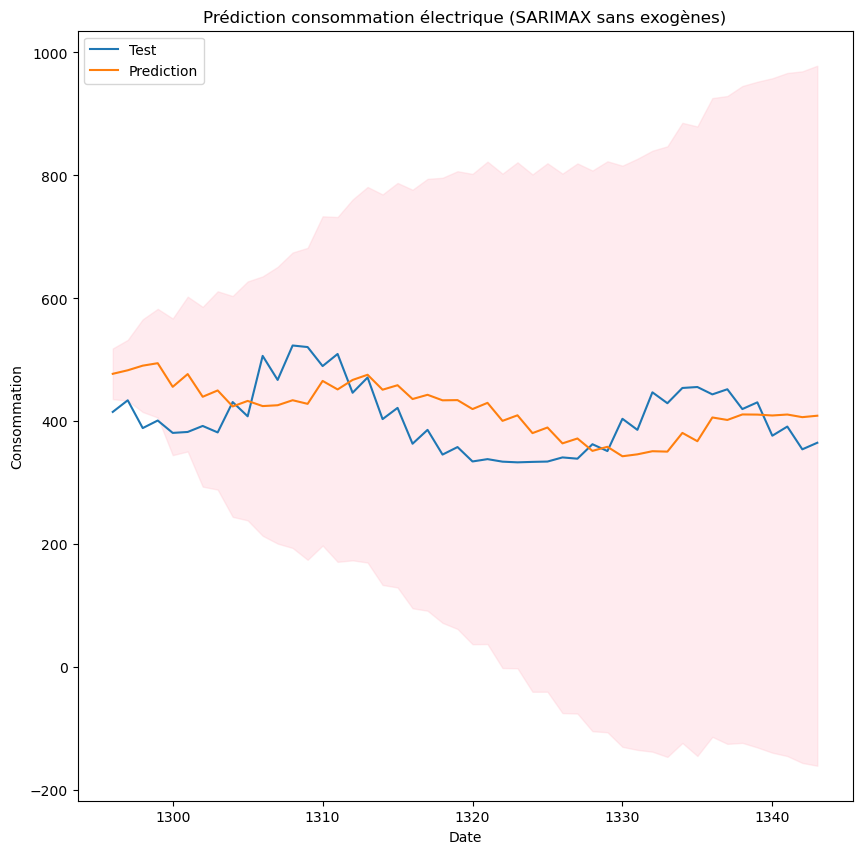

✅ MAE  = 54.38
✅ RMSE = 61.16
✅ MAPE = 13.66%


In [9]:
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction consommation électrique (SARIMAX sans exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mae = mean_absolute_error(test, prediction)
rmse = np.sqrt(mean_squared_error(test, prediction))
mape = mean_absolute_percentage_error(test, prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
$Y_t$ : consommation éléctrique

Première décomposition  $Y_t= S^1_t\times\Theta^1_t\times R^1_t  $

En log :  $log(Y_t)= log(S^1_t)+ log(\Theta^1_t) + log(R^1_t)  $


Deuxième décomposition  $\Theta^1_t= S^2_t\times\Theta^2_t\times R^2_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + log(\Theta^2_t) + log(R^2_t) + log(R^1_t)  $



troisème décomposition  $\Theta^2_t= S^3_t\times\Theta^3_t\times R^3_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + +log(S^3_t) + log(\Theta^3_t) + log(R^3_t) + log(R^2_t) + log(R^1_t)  $


La composante $log(S^1_t)$ est quasi-périodique de période $P_1 = 48$ ==> très bonne approximation avec SARIMA(2,1,0)(1,1,0,48)

La composante $log(S^2_t)$ est quasi-périodique de période $P_2 = 7*48$

La composante $log(S^3_t)$ est quasi-périodique de période $P_3 = 365*48$

In [10]:
# Décomposition 

from statsmodels.tsa.seasonal import seasonal_decompose 
# Premier niveau de décomosition
decomposition_1 = seasonal_decompose(serie, period=48,  model='multiplicative', extrapolate_trend='freq') 
trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
resid_1 = decomposition_1.resid


# Décomposition de la température²
decomposition_T = seasonal_decompose(serie_T, period=48,   extrapolate_trend='freq') #

# Affichage de la décomposition

#decomposition_2.plot()

In [5]:

# Longueur séries  
forceast_long = 365*48
test_long = 2*48





# 


In [ ]:

X_1 =  seasonal_1.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,48)
X_2 =  trend_1.iloc[0: forceast_long]  #  RL par rapport à la 1/température  
X_3 =  resid_1.iloc[0: forceast_long]  # par SARIMAX (5,1,2)(1,1,0,14) 


In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prediction de X_1

X_1_train = X_1.iloc[0:-test_long]
X_1_test =  X_1.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(X_1_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_2 = results_X_1.get_forecast(steps=len(X_1_test))
print("moyenne prediction ...")
X_1_prediction = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()





modèle...
entrainement...
prediction...
moyenne prediction ...
IC...


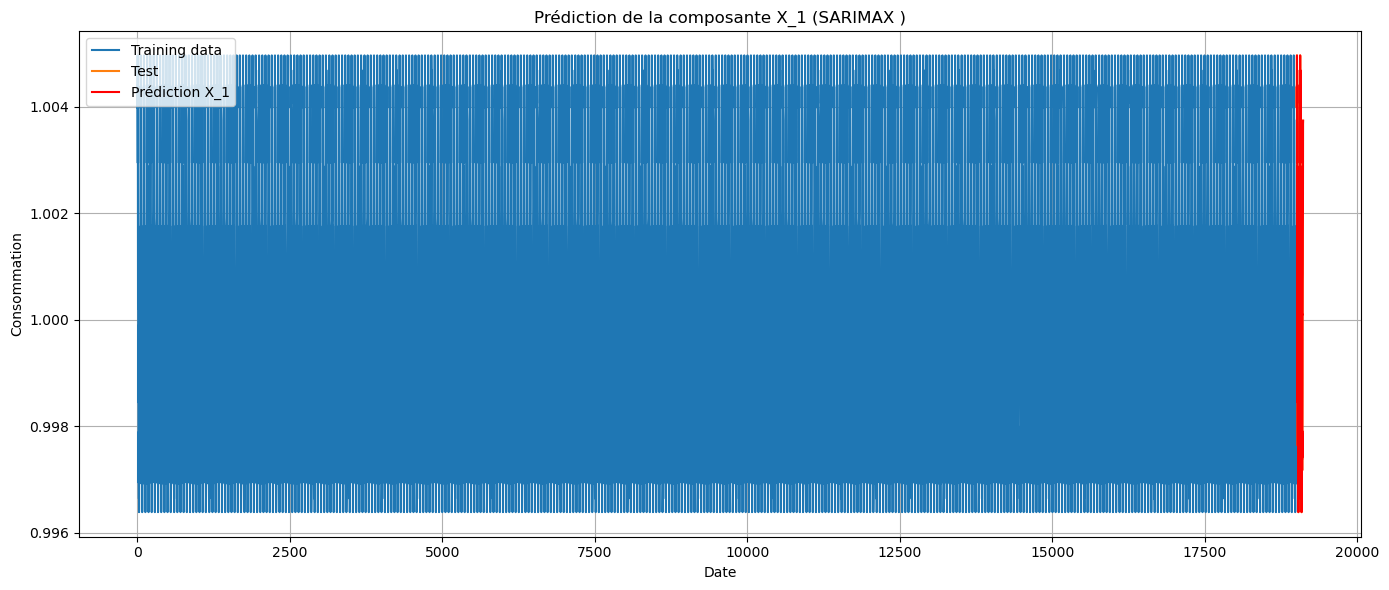

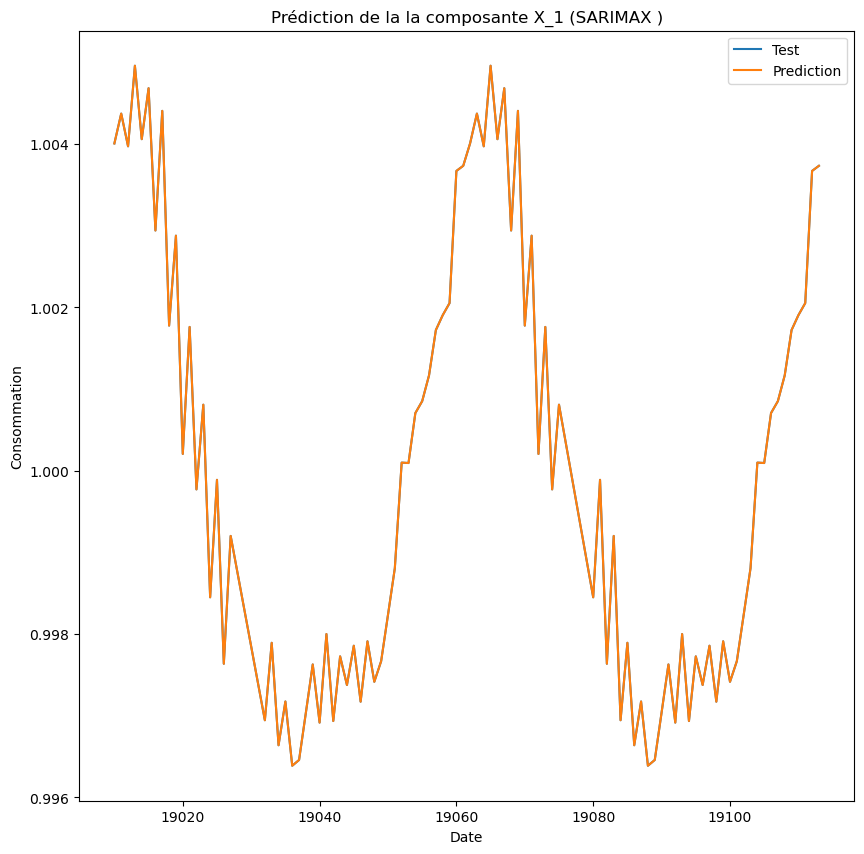

MAPE: 0.00%


In [ ]:
# Visualisation pour X_1 

X_1_prediction = pd.Series(X_1_prediction, index = X_1_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_1_train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
print(f"MAPE: {mape:.2%}")

In [14]:
# Prediction de X_3

X_3_train = X_3.iloc[0:-test_long]
X_3_test =  X_3.iloc[-test_long:]




print("modèle...")

sarima_conso = SARIMAX(X_3_train,
                      order=(5,1,2),
                      seasonal_order=(1,1,1,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False,
                       disp=False)
                      
print("entrainement...")
results_X_3 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_3= results_X_3.get_forecast(steps=len(X_3_test))
print("moyenne prediction ...")
X_3_prediction = forecast_X_3.predicted_mean
print("IC...")
#conf_int = forecast_resid_1.conf_int()

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction...
moyenne prediction ...
IC...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


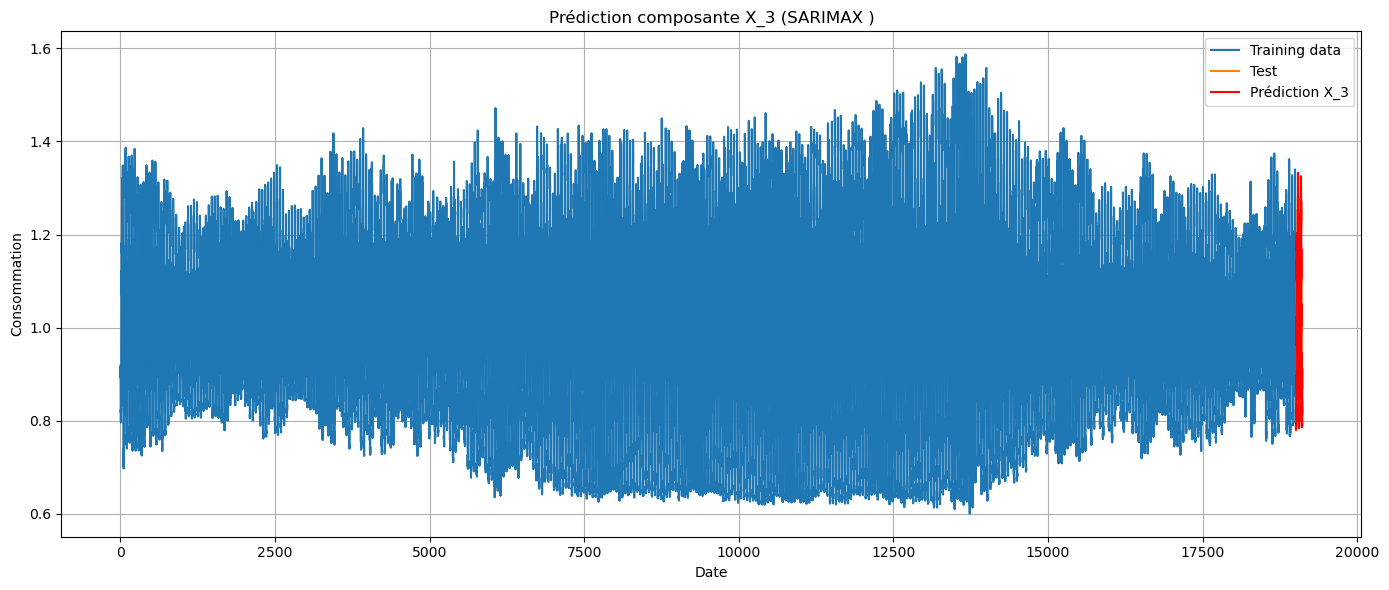

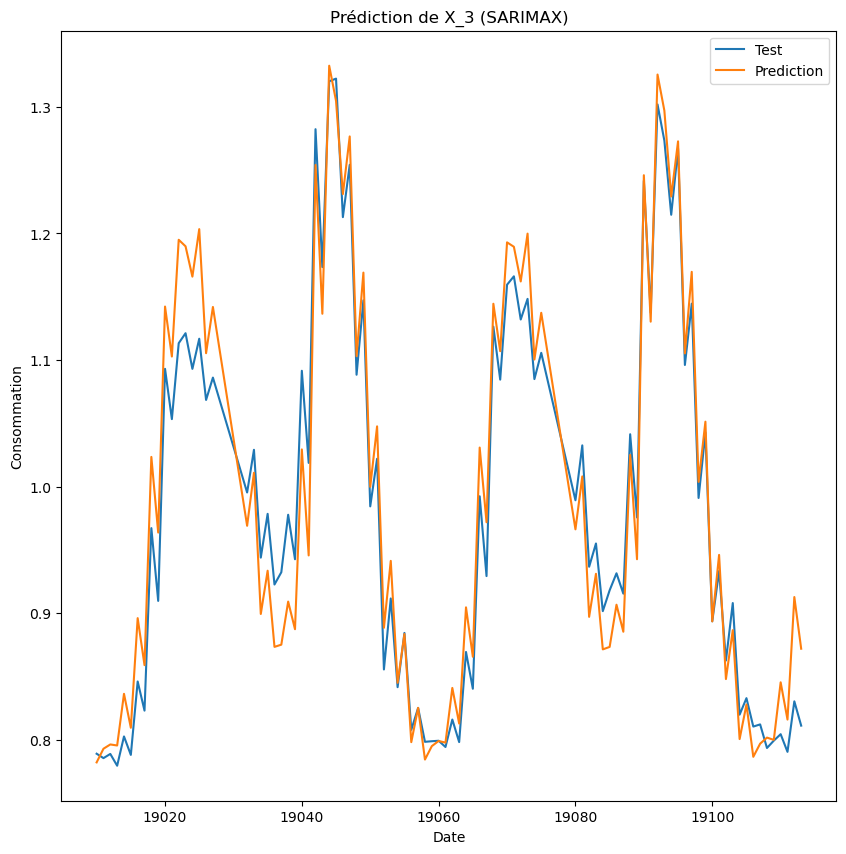

MAPE: 2.94%


In [15]:
# Affichage 
# Visualisation pour X_3
X_3_prediction = forecast_X_3.predicted_mean

X_3_prediction = pd.Series(X_3_prediction.values, index = X_3_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_3_train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label='Prédiction X_3', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction composante X_3 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




#Zoom sur la partie à prédire
plt.figure(figsize=(10,10))
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label ="Prediction")
plt.title("Prédiction de X_3 (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()

mape = mean_absolute_percentage_error(X_3_test, X_3_prediction)
print(f"MAPE: {mape:.2%}")

In [16]:

# Prediction de X_2

X_2_train = X_2.iloc[0:-test_long].diff().dropna()
X_2_test =  X_2.iloc[-test_long:].diff().dropna()

T_train = serie_T.iloc[0: forceast_long-test_long].diff().dropna()
T_test = serie_T.iloc[forceast_long-test_long: forceast_long].diff().dropna()
T_train = 1 /(T_train + 40)
T_test = 1 /(T_test + 40)

print("modèle...")
sarima_conso = SARIMAX(X_2_train.values,order=(1,1,0),
                       seasonal_order=(1,1,0,22),
                       exog=T_train)
                      
print("entrainement...")
results_X_2 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_2 = results_X_2.get_forecast(steps=len(X_2_test), exog=T_test)
print("moyenne prediction ...")
X_2_prediction = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()
X_2_prediction

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prediction...
moyenne prediction ...
IC...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


17423   -0.194400
17424    0.102893
17425    0.520602
17426    0.773164
17427    1.376942
           ...   
17513    0.635747
17514    0.880399
17515    1.451414
17516    2.027570
17517    1.916197
Name: predicted_mean, Length: 95, dtype: float64

In [17]:
# Reconstitution
X_2_prediction = forecast_X_2.predicted_mean
print(X_2_prediction)
X_2_train = X_2.iloc[0:-test_long]
X_2_test =  X_2.iloc[-test_long:]
X_2_prediction_n = pd.Series(np.zeros(len(X_2_test)), index=X_2_test.index)
X_2_prediction_n.iloc[0] =  X_2_test.iloc[0]
for i in range(1,len(X_2_prediction)+1):
   X_2_prediction_n.iloc[i] = X_2_prediction.iloc[i-1] + X_2_prediction_n.iloc[i-1]
X_2_prediction = X_2_prediction_n
X_2_prediction

17423   -0.194400
17424    0.102893
17425    0.520602
17426    0.773164
17427    1.376942
           ...   
17513    0.635747
17514    0.880399
17515    1.451414
17516    2.027570
17517    1.916197
Name: predicted_mean, Length: 95, dtype: float64


date
19010    296.362191
19011    296.167791
19012    296.270684
19013    296.791286
19014    297.564450
            ...    
19109    292.686948
19110    293.567348
19111    295.018762
19112    297.046332
19113    298.962529
Length: 96, dtype: float64

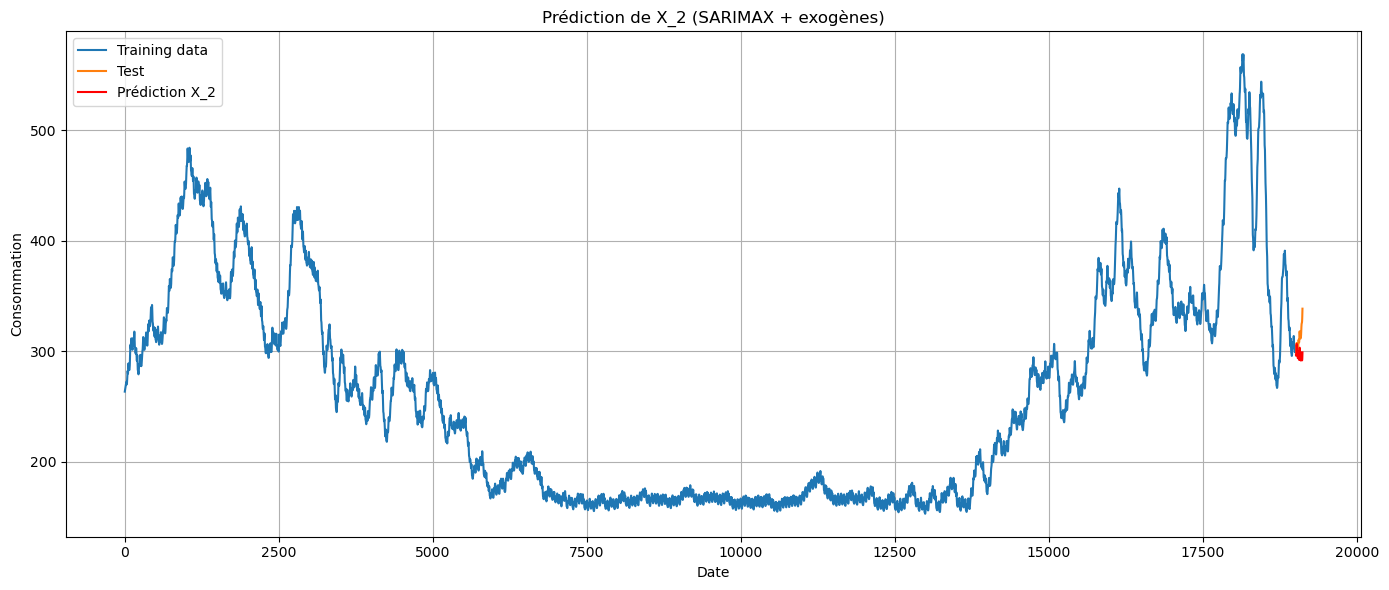

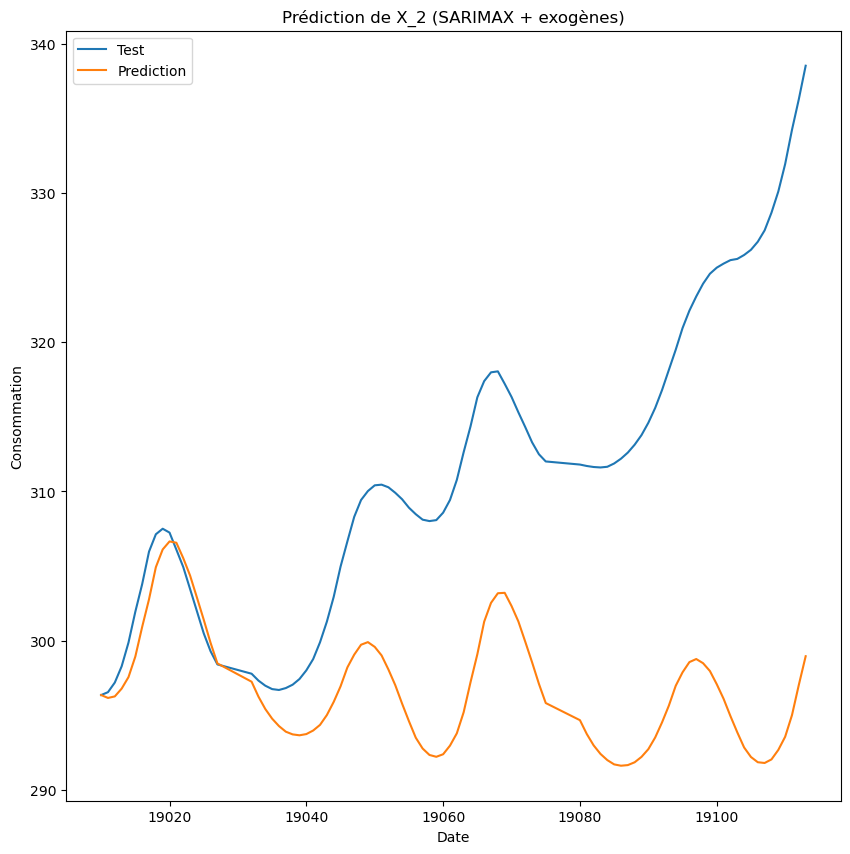

MAPE: 4.64%


In [18]:
# Visualisation pour X_2

#X_2_prediction = pd.Series(X_2_prediction, index = X_2_test.index)
#X_2_prediction.index = X_2_test.index
plt.figure(figsize=(14, 6))
plt.plot(X_2_train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label='Prédiction X_2', color='red')
#plt.fill_between(X_2_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de X_2 (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de X_2 (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()





mape = mean_absolute_percentage_error(X_2_test, X_2_prediction)
print(f"MAPE: {mape:.2%}")

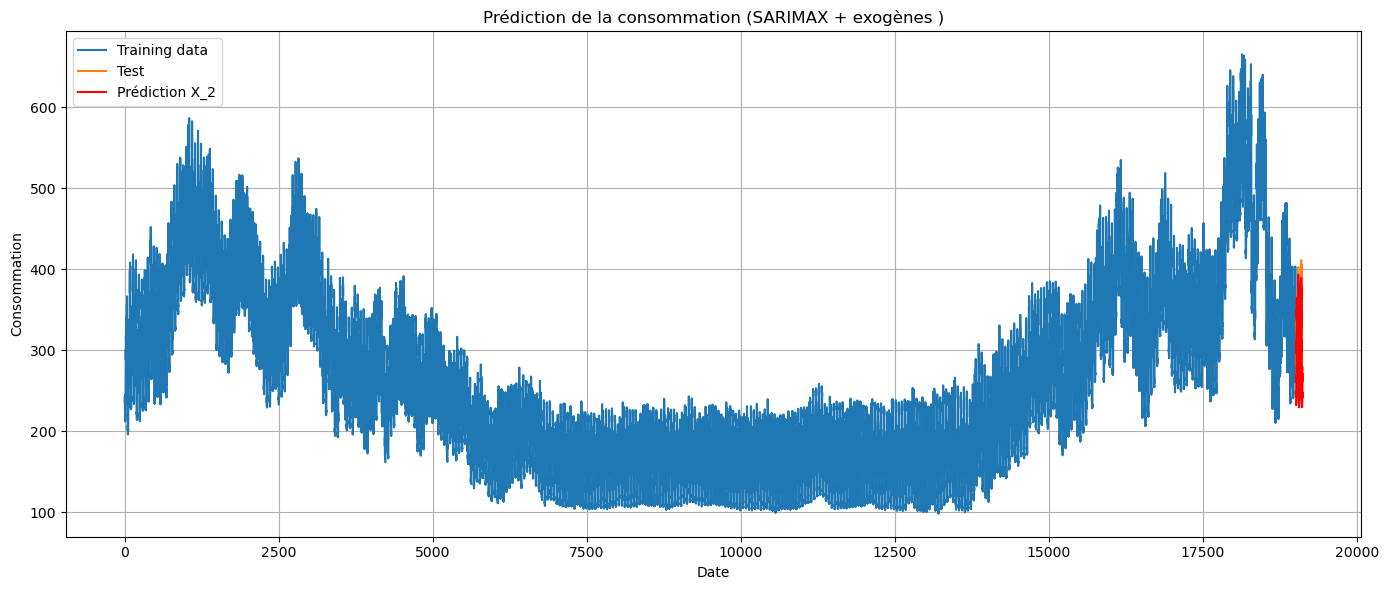

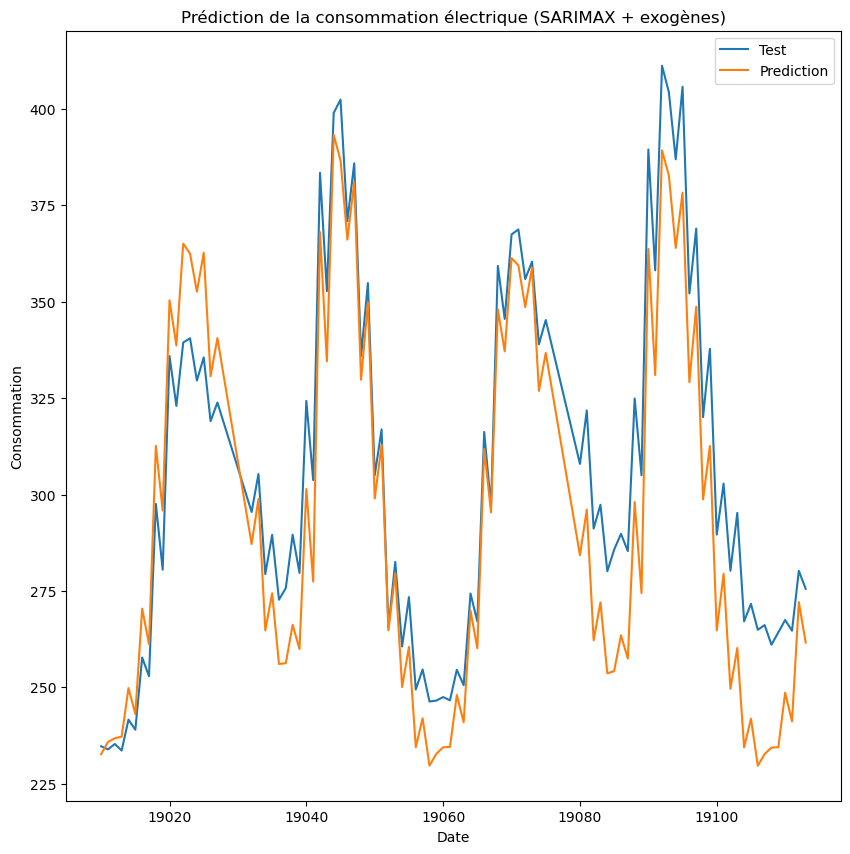

✅ MAE  = 16.37
✅ RMSE = 18.90
✅ MAPE = 5.43%


In [19]:
# prediction globale  X_1*X_2*X_3

serie1 = pd.Series(serie['consommation'], index=serie.index)
serie1 = serie1.iloc[0:forceast_long]
serie_train = serie1.iloc[0:-test_long] # X_1_train*X_2_train*X_3_train # serie.iloc[0:-test_long]
serie_test =serie1.iloc[-test_long:]  #  X_1_test*X_2_test*X_3_test #serie.iloc[-test_long:]

serie_prediction = pd.Series((X_1_prediction*X_2_prediction*X_3_prediction).values, index = serie_test.index)



plt.figure(figsize=(14, 6))
plt.plot(serie_train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label='Prédiction X_2', color='red')
#plt.fill_between(serie_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la consommation (SARIMAX + exogènes )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()





# Métriques
mae = mean_absolute_error(serie_test, serie_prediction)
rmse = np.sqrt(mean_squared_error(serie_test, serie_prediction))
mape = mean_absolute_percentage_error(serie_test, serie_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

In [126]:
# Prédiction de X_2 par NN regression

# Packages 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import train_test_split

# Préparation du DataFrame 
df = sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 

df["y"] = trend_1.values # la cible est la tendence de la consommation normalisée par le nombre de points de soutirage


# Construction du timestamp 'ds' : peut être utile si on introduit des fct trigo pour la périodicité
df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

# Renommer la cible
df = df.rename(columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Nb points soutirage": "Nb"
})

# Garder uniquement les variables exogènes (regressors)
df = df[[ 'y', 'T', 'U', 'FF']].dropna().drop_duplicates()

# Séparation des variables
X = df.drop(columns='y')
y = df['y']


X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = 1/(X['T']+40)
# Normalisation
from sklearn import preprocessing
minmax_scaler = preprocessing.MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)



# séparation test & entrainement 
#X_train = X_scaled[:-test_long]
#X_test = X_scaled[-test_long:]

#y_train = y[:-test_long]
#y_test = y[-test_long:]

# Modèle DNN 
# Architecture 
# Couche d'entrée
#dnn_model  = Sequential([Input(shape=(3,))])

# Couche 1 & 2  
# dnn_model.add(Dense(units=128, activation="tanh")) 
# dnn_model.add(Dense(units=64, activation="tanh"))

# Couche de sortie
# dnn_model.add(Dense(units=1)) 


# Modèle 2 
def create_sequences(df, window_size):
    #X, y = [], []
    X = []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :-1])
        #y.append(yin[i])  # Consommation comme cible
    return np.array(X)

window_size = 24  #  48 pas (24 heures  * 2 intervalle de 30 minutes)

X_scaled_sequenced = create_sequences(X_scaled,window_size)




# séparation test & entrainement 
X_train = X_scaled_sequenced[:-test_long]
X_test = X_scaled_sequenced[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]



dnn_model = Sequential([LSTM(64, input_shape =(X_scaled_sequenced.shape[1], X_scaled_sequenced.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(1)])


# Résumé du modèle
dnn_model.summary()


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compilation du modèle

opt_1 = tf.optimizers.Adam(learning_rate=0.01)
dnn_model.compile(loss="mean_absolute_error",
             optimizer=opt_1,
             metrics=["mape"])

params = {'validation_split' : 0.2 , 'epochs' : 100, 'batch_size' : 32} 

dnn_history = dnn_model.fit(X_train, y_train,
         validation_split=params['validation_split'],
         epochs=params['epochs'], 
         batch_size=params['batch_size'],
         callbacks=[early_stopping, lr_scheduler])



# Prédiction
y_pred =  dnn_model.predict(X_test).flatten()
X_2_prediction_dnn = y_pred 






NameError: name 'trend_1' is not defined

In [ ]:
X_2_prediction_dnn

array([316.16055, 318.20773, 320.59387, 323.96683, 329.82724, 334.2571 ,
       343.52133, 346.33804, 352.54605, 353.9319 , 357.0023 , 357.4728 ,
       358.88498, 358.16425, 357.76318, 356.23032, 354.42206, 352.42703,
       349.76114, 347.61594, 344.3971 , 342.0103 , 338.77182, 337.22003,
       335.35727, 334.3345 , 332.48187, 331.70776, 330.5881 , 329.7643 ,
       328.66898, 327.86548, 326.6191 , 325.3691 , 323.69693, 322.2737 ,
       320.61334, 319.505  , 317.6052 , 316.27304, 311.08337, 311.1721 ,
       310.74985, 311.2086 , 311.46457, 312.37332, 313.36325, 314.78638,
       316.91824, 318.88278, 322.21844, 324.2604 , 327.68906, 329.61588,
       333.01352, 334.61652, 337.68875, 338.9218 , 341.2754 , 342.20865,
       343.40247, 344.69058, 346.5977 , 347.58524, 348.9916 , 349.36697,
       350.51572, 350.81256, 351.92044, 352.1124 , 352.69205, 352.40115,
       352.19272, 352.0566 , 352.13132, 352.52866, 352.6767 , 353.17868,
       353.49078, 353.8722 , 354.08218, 354.74115, 

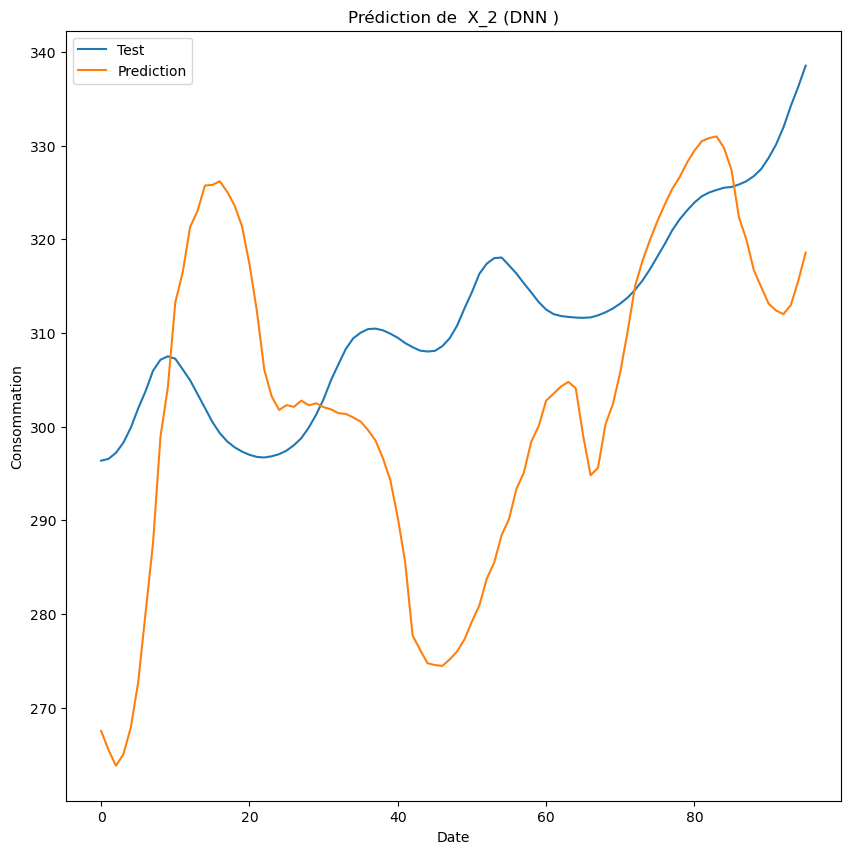

In [ ]:
# # Affichage pour X_2 prédit par DNN


# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(y_test.values, label ='Test')
plt.plot(y_pred, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de  X_2 (DNN )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

plt.show()





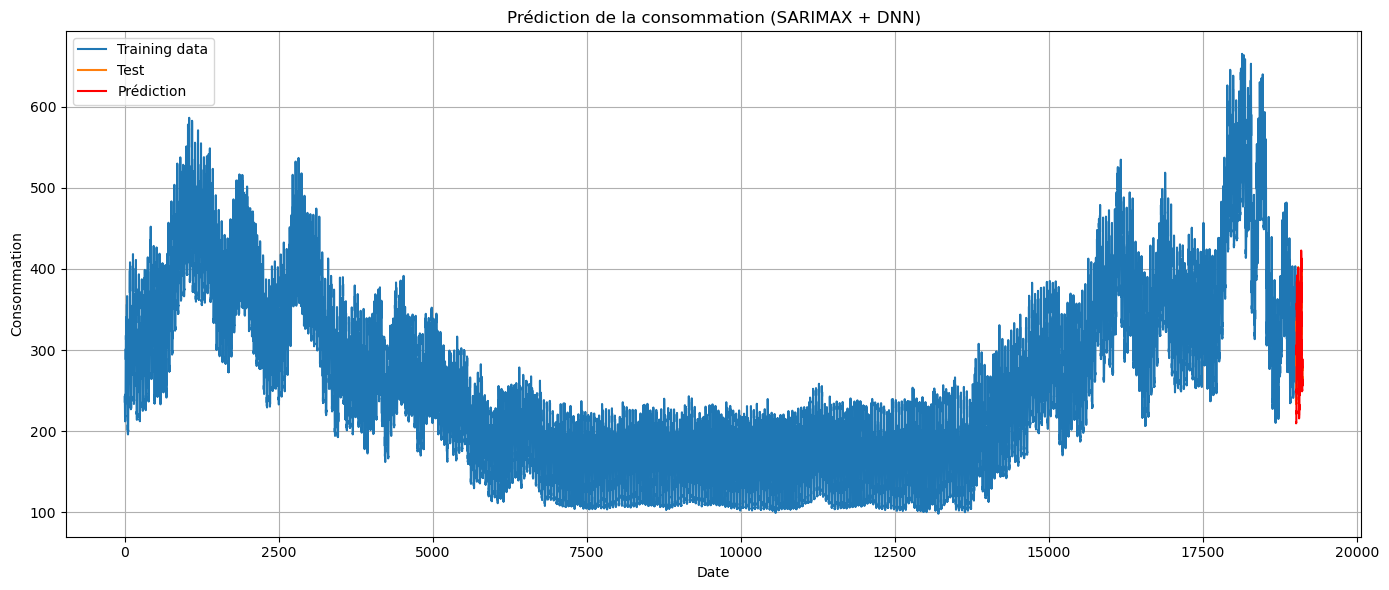

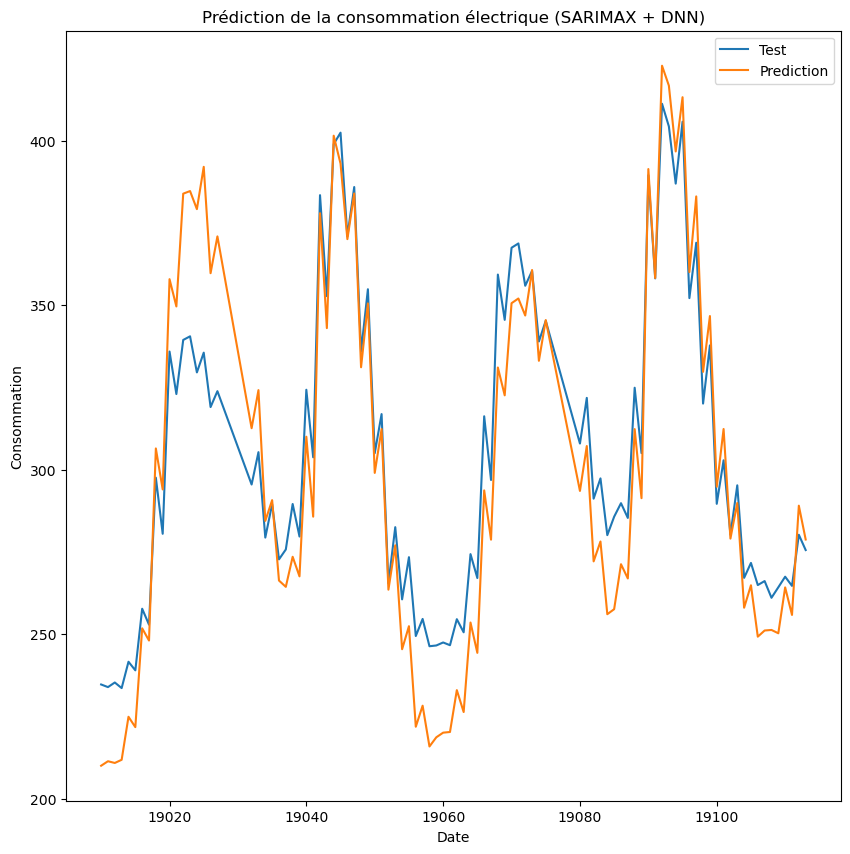

✅ MAE  = 15.45
✅ RMSE = 19.26
✅ MAPE = 5.27%


In [ ]:
# prediction globale  X_1*X_2*X_3


serie1 = pd.Series(serie['consommation'], index=serie.index)
serie1 = serie1.iloc[0:forceast_long]
serie_train = serie1.iloc[0:-test_long] # X_1_train*X_2_train*X_3_train # serie.iloc[0:-test_long]
serie_test =serie1.iloc[-test_long:]  #  X_1_test*X_2_test*X_3_test #serie.iloc[-test_long:]

serie_prediction = pd.Series((X_1_prediction*X_2_prediction_dnn*X_3_prediction).values, index = serie_test.index)



plt.figure(figsize=(14, 6))
plt.plot(serie_train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label='Prédiction', color='red')
#plt.fill_between(serie_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la consommation (SARIMAX + DNN)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la consommation électrique (SARIMAX + DNN)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mape = mean_absolute_percentage_error(serie_test, serie_prediction)
# Métriques
mae = mean_absolute_error(serie_test, serie_prediction)
rmse = np.sqrt(mean_squared_error(serie_test, serie_prediction))
mape = mean_absolute_percentage_error(serie_test, serie_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

********************************************************************
********************************************************************
********************************************************************

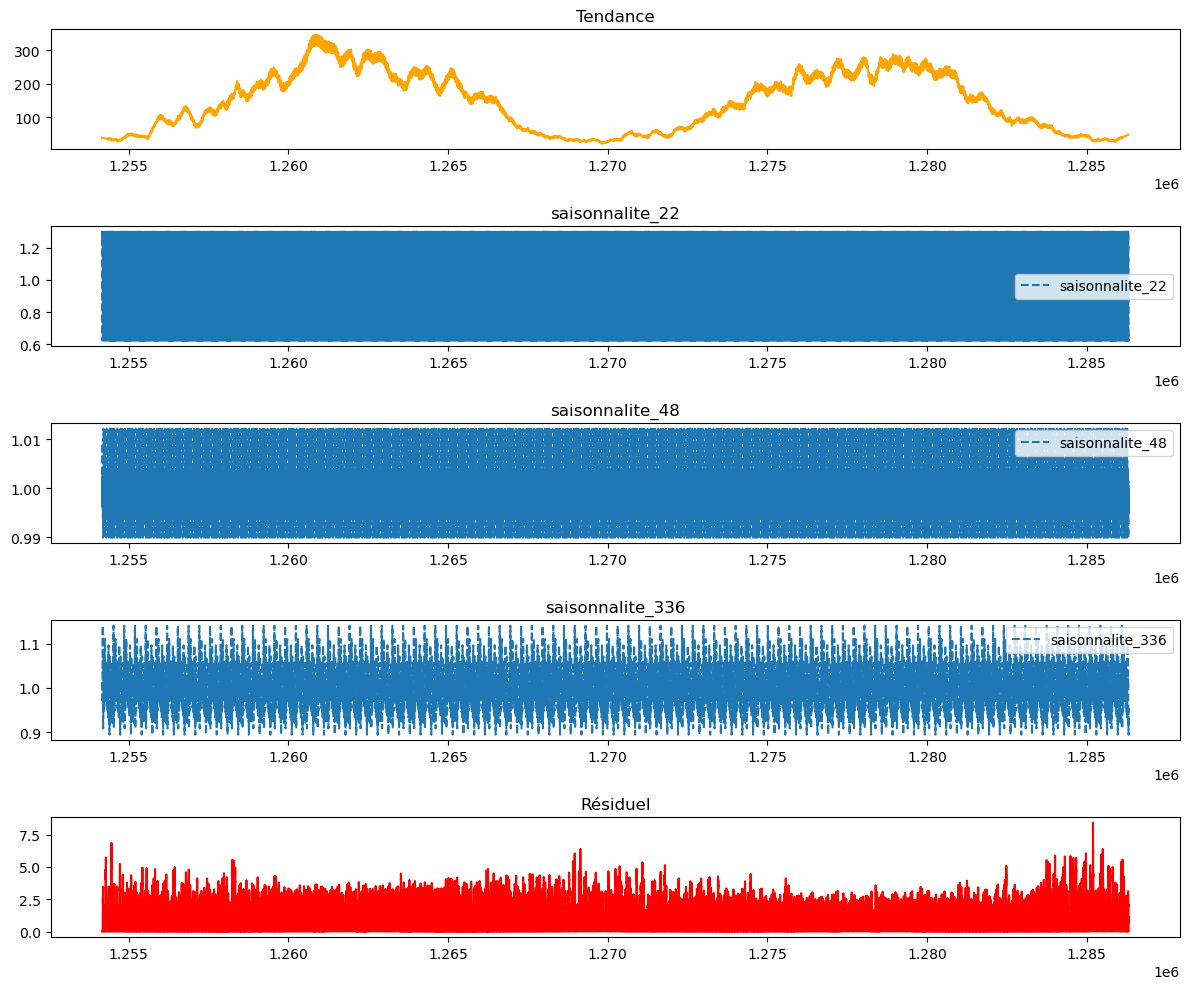

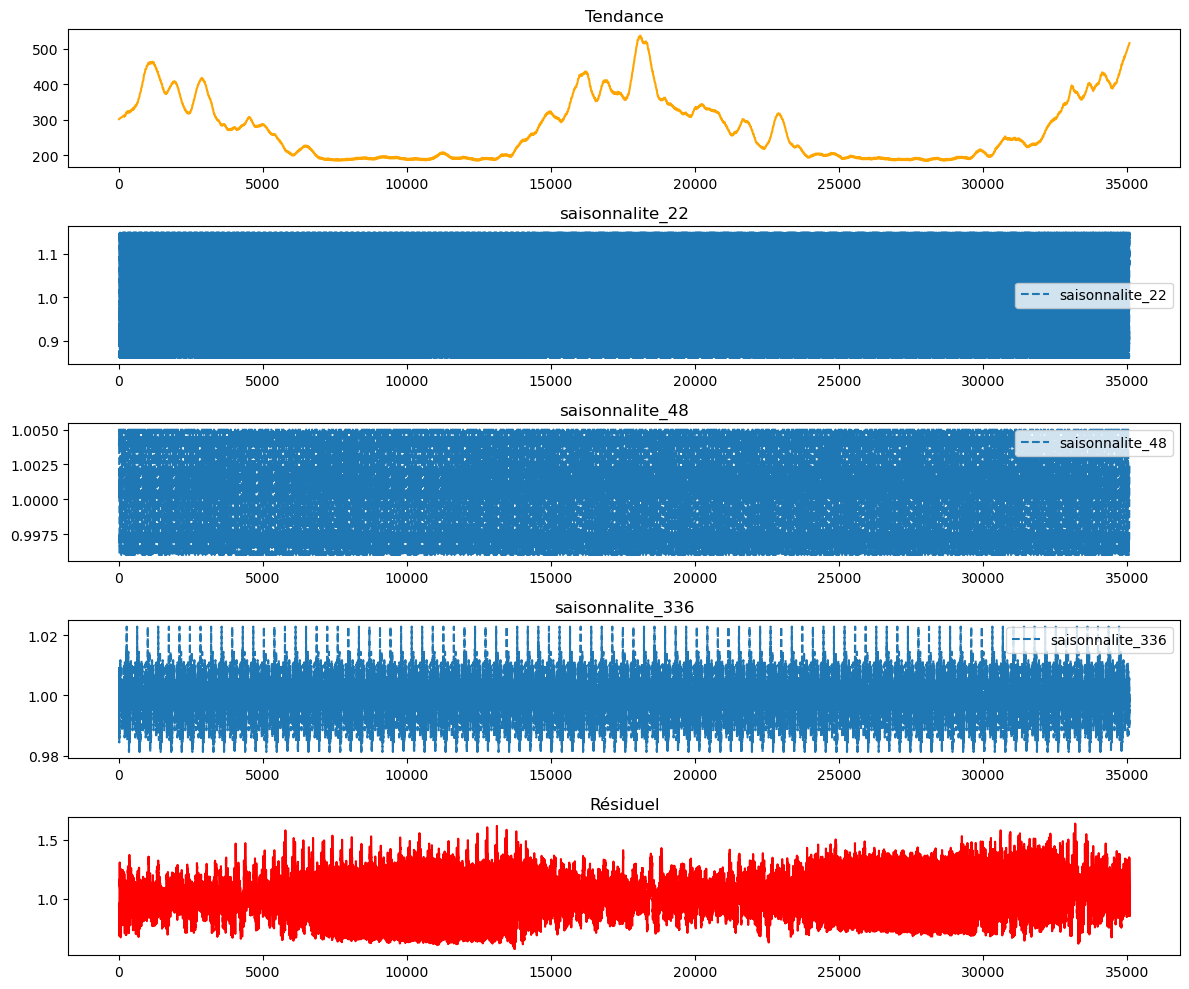

In [208]:
from DecompositionSerieTemporelle import DecompositionSerieTemporelle
# Exemple d'utilisation
if __name__ == "__main__":
    # Chargement de la série temporelle
    XX = sub_df
    #decomposer = DecompositionSerieTemporelle(colonne='consommation', forme = 'multiplicative')
    decomposer = DecompositionSerieTemporelle(colonne='Rayonnement solaire global (W/m2)', forme = 'multiplicative', periodes = [22,48,336])
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()


    S = pd.DataFrame(d)
    XX = serie
    decomposer = DecompositionSerieTemporelle(colonne='consommation', forme = 'multiplicative',periodes = [22,48,336])
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()

In [210]:
serie_transforme.head()

,consommation,consommation_tendance,consommation_residuel,consommation_saisonnalite_22,consommation_saisonnalite_48,consommation_saisonnalite_336
date,,,,,,
0,246.817222,301.445311,0.940272,0.860187,1.003817,1.008478
1,254.190177,301.509249,0.958111,0.869633,1.004121,1.007674
2,233.606620,301.573188,0.879966,0.870104,1.004052,1.007625
3,240.642429,301.637126,0.911152,0.863000,1.005008,1.009524
4,227.216541,301.701065,0.804117,0.924703,1.003916,1.008891


In [209]:

decomposer.fit(serie)
serie_transforme = decomposer.transform(serie)
X_1 =  serie_transforme.saisonnalite_22.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,22)
X_2 =  serie_transforme.saisonnalite_48.iloc[0: forceast_long]  #  par SARIMAX (2,1,1)(1,1,0,48)
X_3 =  serie_transforme.saisonnalite_336.iloc[0: forceast_long]  # par SARIMAX (2,1,2)(1,1,0,336) 
X_4 =  serie_transforme.tendance.iloc[0: forceast_long] # RL
X_5 =  serie_transforme.residuel.iloc[0: forceast_long] #par SARIMAX (2,1,1)(1,1,0,48)




AttributeError: 'DataFrame' object has no attribute 'saisonnalite_22'

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    result = adfuller(series)
    print("Statistique de test ADF:", result[0])
    print("P-valeur:", result[1])
    print("Valeurs critiques:", result[4])
    
    if result[1] < 0.05:
        print("La série est stationnaire (rejeter l'hypothèse nulle).")
    else:
        print("La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle).")

In [ ]:
test_stationarity(X_5)

Statistique de test ADF: -10.93476386693442
P-valeur: 9.622108362047911e-20
Valeurs critiques: {'1%': -3.4353061595148073, '5%': -2.863728748588099, '10%': -2.567935298646666}
La série est stationnaire (rejeter l'hypothèse nulle).


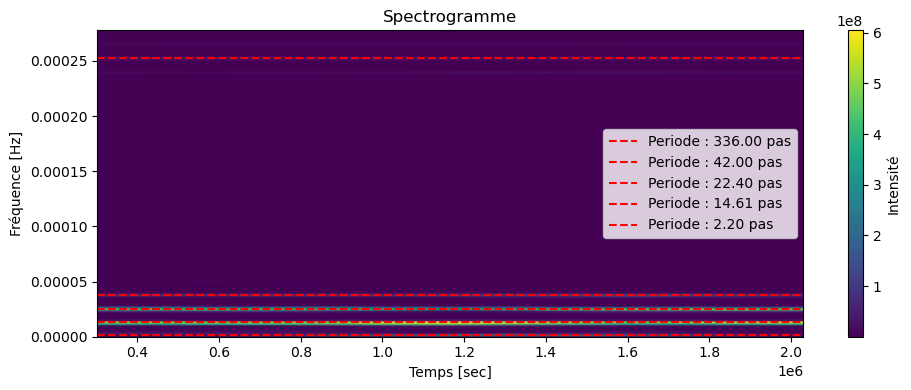

Fréquences des raies spectrales (X pas de 30 minutes) : [  2.  14.  22.  42. 336.]


In [ ]:
from AnalyseSpectrale import SpectrogramAnalysis

XX = X_1*X_2*X_3*X_4*X_5
# Initialiser et ajuster l'analyse du spectrogramme
spectrogram_analyzer = SpectrogramAnalysis(window='hann', nperseg=7*48, noverlap=2*48, fs= 1/1800, threshold=0.05)
spectrogram_analyzer.fit(XX)
spectrogram_analyzer.transform(XX)
spectrogram_analyzer.plot_spectrogramme()
    # Transformer pour obtenir les fréquences dominantes

print("Fréquences des raies spectrales (X pas de 30 minutes) :", spectrogram_analyzer.dominant_periodes)



In [12]:

import PipelineAnalyseSpectraleDecomposition 
import importlib

importlib.reload(PipelineAnalyseSpectraleDecomposition)

from PipelineAnalyseSpectraleDecomposition import SpectroDecompPipeline



pipeline = SpectroDecompPipeline(
    colonne='y',
    forme='multiplicative',
    spectro_kwargs={'window' : 'hann', 'nperseg' : 7*48, 'noverlap' : 2*48, 'fs' : 1/1800, 'threshold' : 0.05}
)

df_transformed = pipeline.fit_transform(sub_df)  # df contient la colonne 'consommation'

pipeline = SpectroDecompPipeline(
    colonne='T',
    forme='multiplicative',
    spectro_kwargs={'window' : 'hann', 'nperseg' : 7*48, 'noverlap' : 2*48, 'fs' : 1/1800, 'threshold' : 0.05}
)
df_transformed = pipeline.fit_transform(df_transformed)  # df contient la colonne 'consommation'

In [16]:
liste1 = [1, 2, 3]
liste2 = ['a', 'b', 'c']
for element1, element2 in zip(liste1, liste2):
    print(element1, element2)

1 a
2 b
3 c


In [215]:
X_1 =  df_transformed.consommation_saisonnalite_22.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,22)
X_2 =  df_transformed.consommation_saisonnalite_42.iloc[0: forceast_long]  #  par SARIMAX (2,1,1)(1,1,0,48)
X_3 =  df_transformed.consommation_saisonnalite_336.iloc[0: forceast_long]  # par SARIMAX (2,1,2)(1,1,0,336) 
X_4 =  df_transformed.consommation_tendance.iloc[0: forceast_long] # RL
X_5 =  df_transformed.consommation_residuel.iloc[0: forceast_long] #par SARIMAX (2,1,1)(1,1,0,48)

In [206]:
X_1_prediction.index

RangeIndex(start=1248, stop=1344, step=1)

In [226]:
serie.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       35076, 35077, 35078, 35079, 35080, 35081, 35082, 35083, 35084, 35085],
      dtype='int32', name='date', length=32158)

c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


... predict


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


moyenne prediction ...
IC...


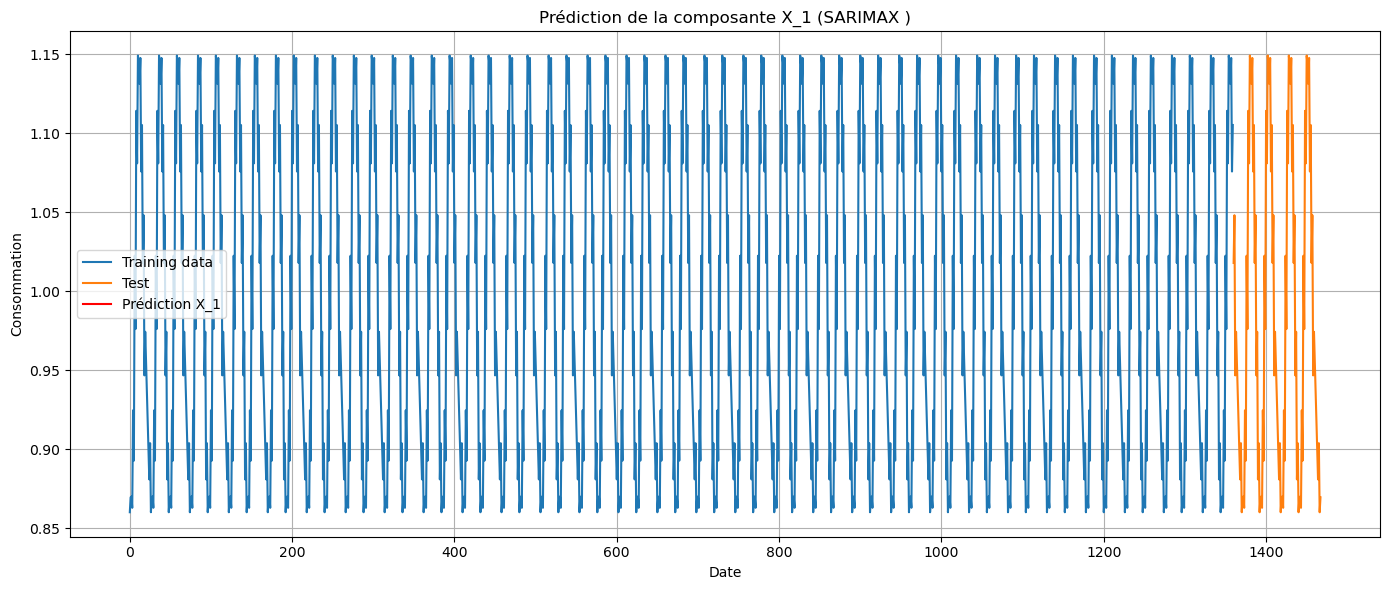

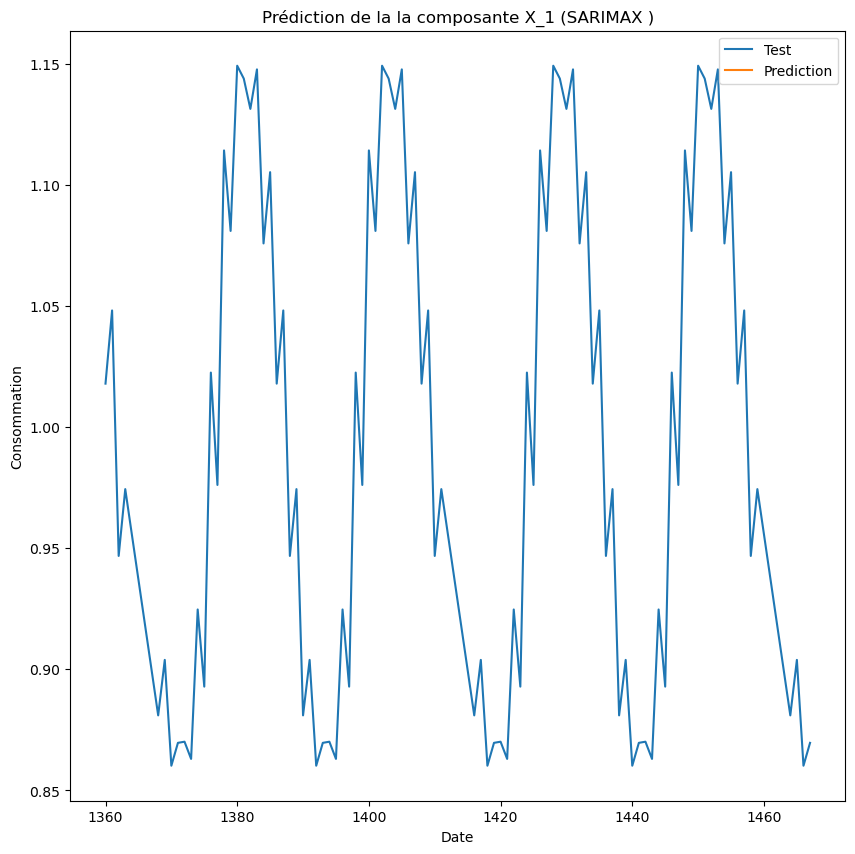

ValueError: Input contains NaN.

In [217]:
# Visualisation pour X_2 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from SarimaxModels import SARIMAModel
from LstmModel import LSTMModel
import pandas as pd
import numpy as np 


import SarimaxModels
import importlib
# clear the import cache
importlib.reload(SarimaxModels)
# now you can import my_class and it'll be updated
from SarimaxModels import SARIMAModel

# Prediction de X_1

X_1_train = X_1.iloc[:-test_long]
X_1_test =  X_1.iloc[-test_long:]
"""
print("modèle...")
sarima_conso = SARIMAX(X_1_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")

"""
sarima_conso = SARIMAModel(period=22, research_best_model = False)
sarima_conso.fit(X_1_train)
forecast_X_1= sarima_conso.predict(X_1_test)
print("moyenne prediction ...")
X_1_prediction = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()

X_1_prediction = pd.Series(X_1_prediction, index = X_1_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_1_train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_1_prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
print(f"MAPE: {mape:.2%}")

In [ ]:
X_2.index

RangeIndex(start=0, stop=192, step=1)

modèle...
... predict


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_

IC...


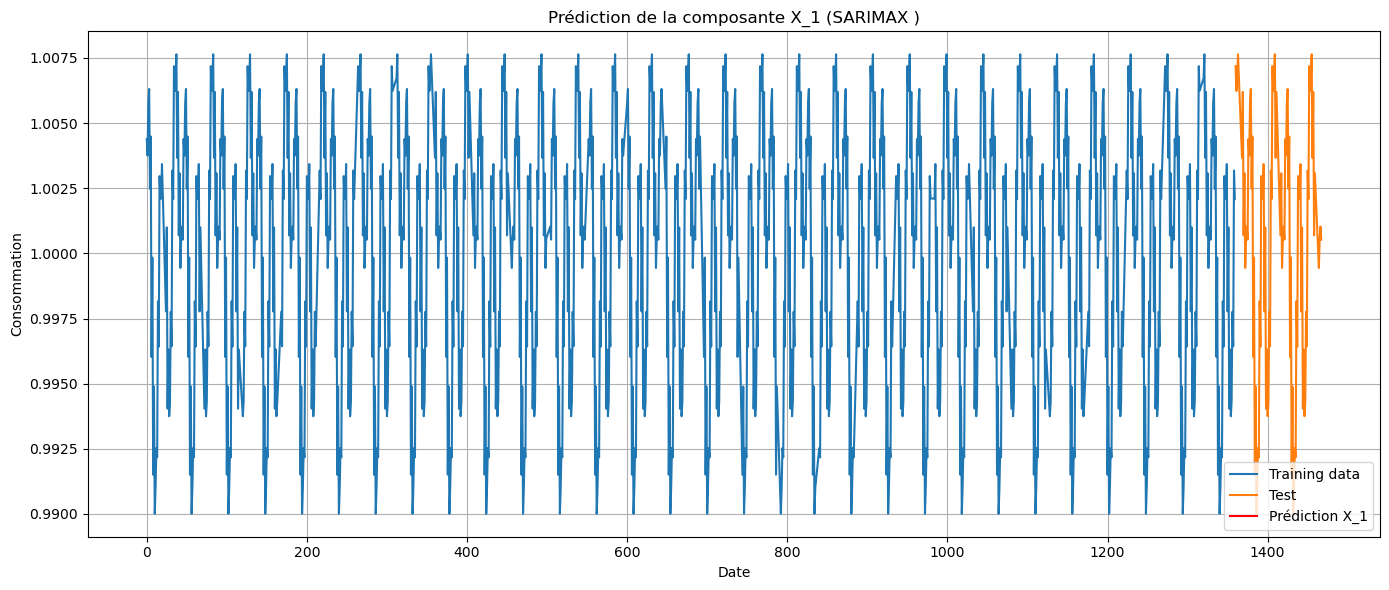

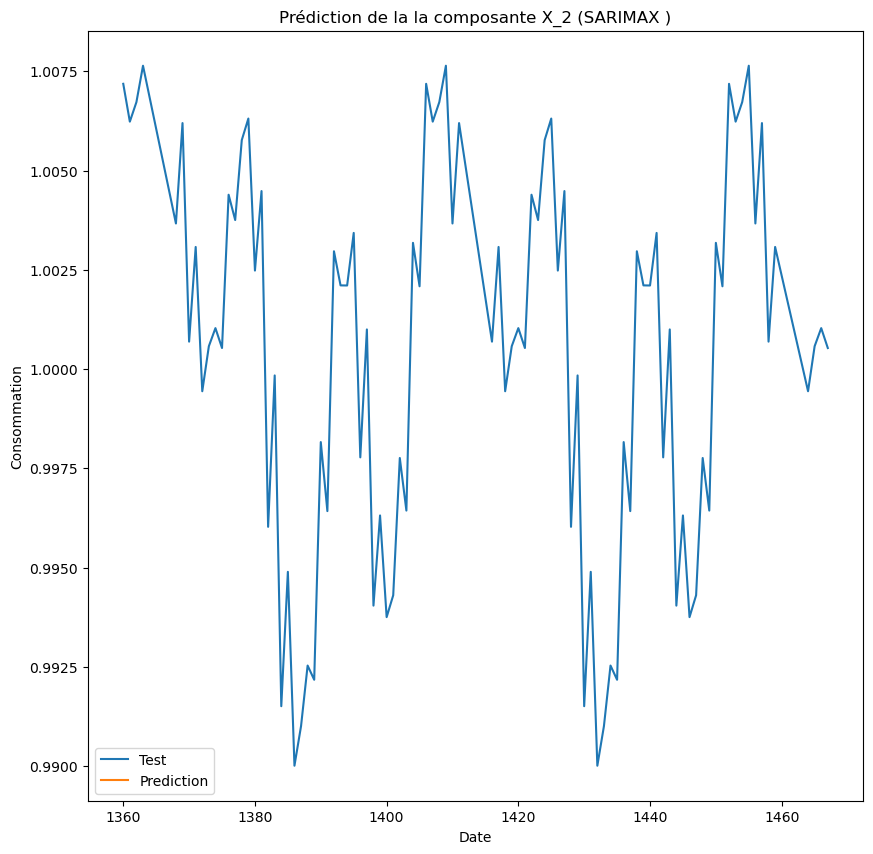

ValueError: Input contains NaN.

In [270]:
# Visualisation pour X_2 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from SarimaxModels import SARIMAModel
from LstmModel import LSTMModel
import pandas as pd
import numpy as np 


import SarimaxModels
import importlib
# clear the import cache
importlib.reload(SarimaxModels)
# now you can import my_class and it'll be updated
from SarimaxModels import SARIMAModel



X_2_train = X_2.iloc[:-test_long]
X_2_test =  X_2.iloc[-test_long:]



print("modèle...")
"""
sarima_conso = SARIMAX(X_2_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

#
"""

sarima_conso = SARIMAModel(period=42, research_best_model = False)
sarima_conso.fit(X_2_train)
forecast_X_2 = sarima_conso.predict(X_2_test)

X_2_prediction = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()

X_2_prediction = pd.Series(X_2_prediction.values, index = X_2_test.index)



plt.figure(figsize=(14, 6))
plt.plot(X_2_train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_2_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label ="Prediction")

plt.fill_between(X_2_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_2_test, X_2_prediction)
print(f"MAPE: {mape:.2%}")

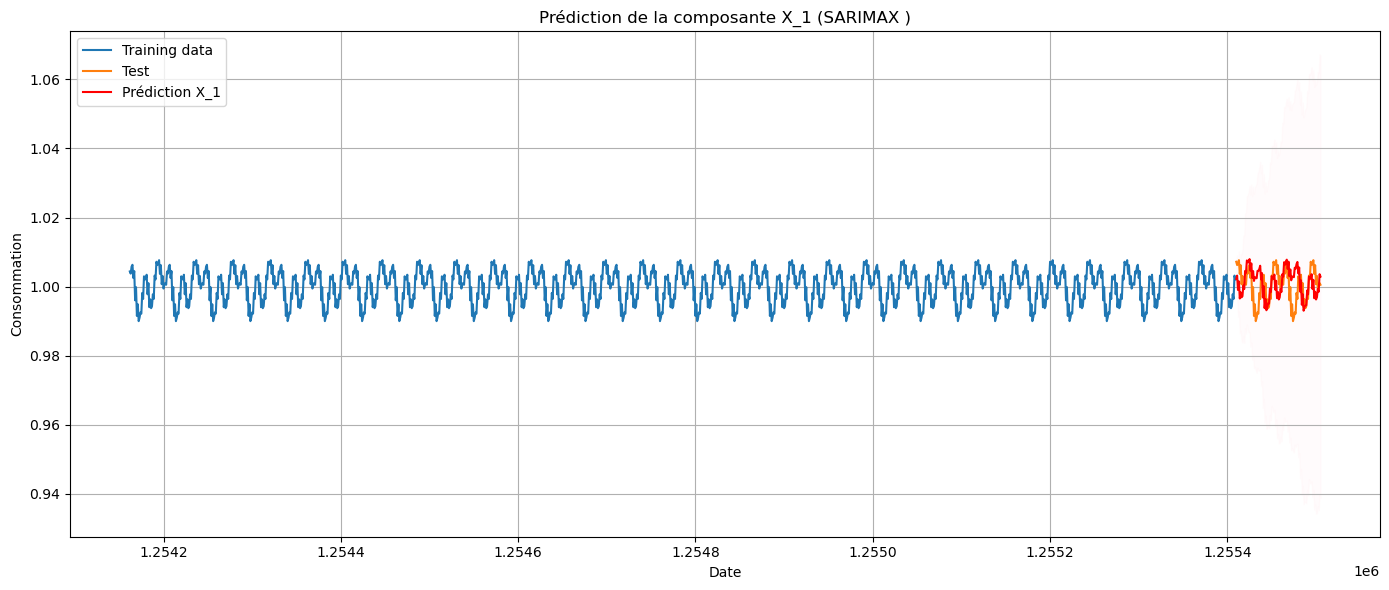

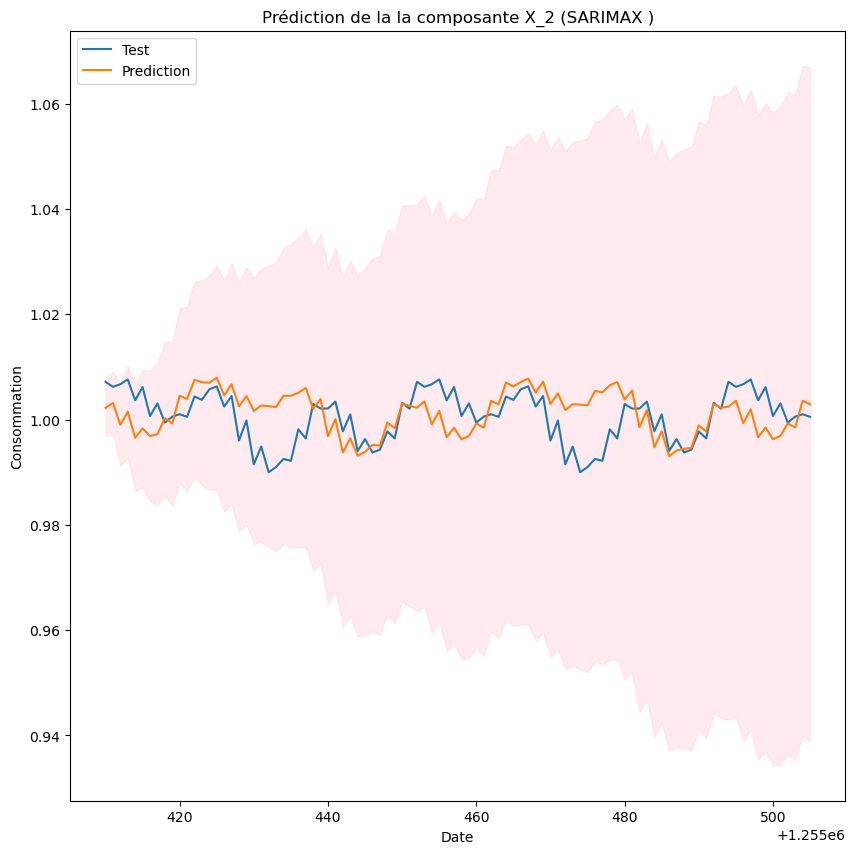

In [185]:

plt.figure(figsize=(14, 6))
plt.plot(X_2_train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_2_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 

# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label ="Prediction")

plt.fill_between(X_2_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt





c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


... fit


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


IC...
IC...
MAPE: 1.98%


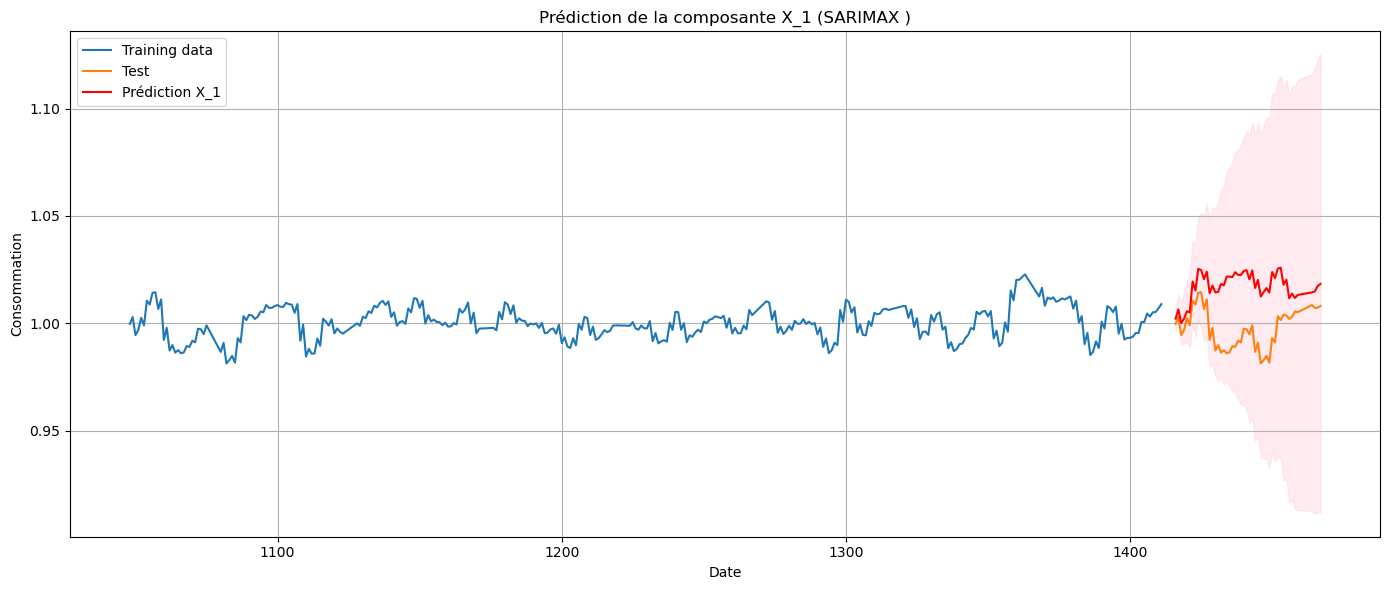

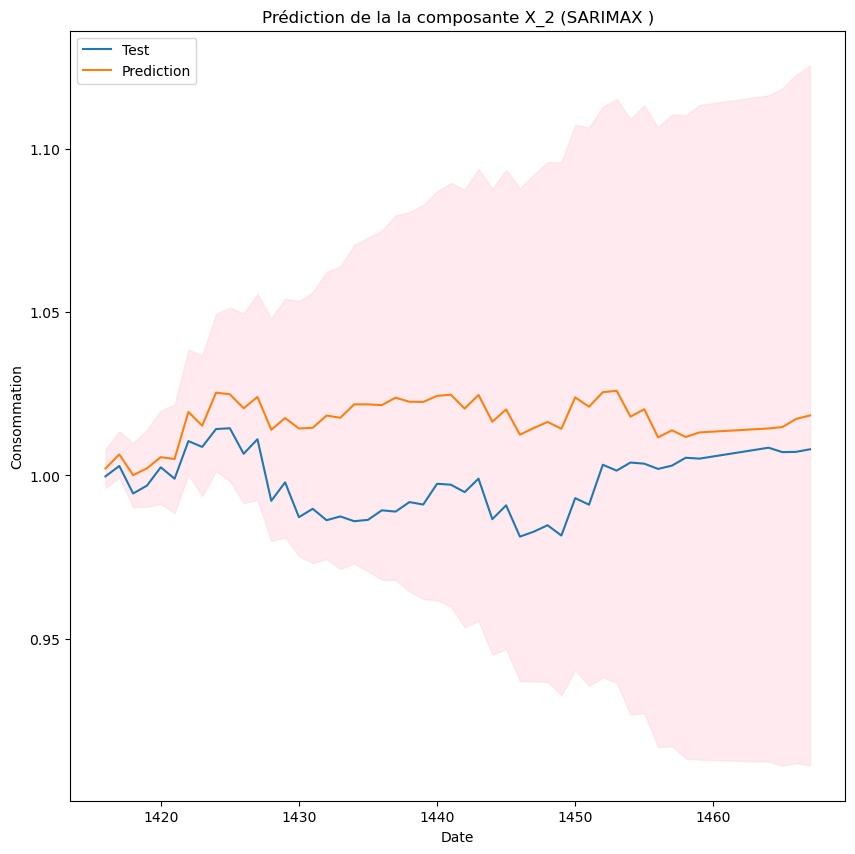

MAPE: 1.98%


In [ ]:
X_3_train = X_3.iloc[len(X_3) - 8*test_long:len(X_3)-test_long]
X_3_test =  X_3.iloc[-test_long:]



sarima_conso = SARIMAModel(period=112, research_best_model = False)
sarima_conso.fit(X_3_train)
forecast_X_3 = sarima_conso.predict(X_3_test)

X_3_prediction = forecast_X_3.predicted_mean
print("IC...")
conf_int = forecast_X_3.conf_int()

X_3_prediction = pd.Series(X_3_prediction.values, index = X_3_test.index)
print("IC...")
#conf_int = forecast_X_2.conf_int()

#sarima_conso.plot_predictions(X_2_test)

mape = mean_absolute_percentage_error(X_3_test, X_3_prediction)
print(f"MAPE: {mape:.2%}")



plt.figure(figsize=(14, 6))
plt.plot(X_3_train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_3_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label ="Prediction")

plt.fill_between(X_3_prediction.index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_3_test, X_3_prediction)
print(f"MAPE: {mape:.2%}")

In [ ]:
X_5_train = X_5.iloc[:-test_long]
X_5_test =  X_5.iloc[-test_long:]

order = sarima_conso.model.order            # (p,d,q)
seasonal_order = sarima_conso.model.seasonal_order  # (P,D,Q,s)
       
sarima_conso = SARIMAX(X_5_train ,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)

model_fit = sarima_conso.fit()
output = model_fit.get_forecast(steps=len(X_5_test))


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_

In [ ]:
X_5_train = X_5.iloc[:-test_long]
X_5_test =  X_5.iloc[-test_long:]

sarima_conso = SARIMAModel(period=14, research_best_model = False)
sarima_conso.fit(X_5_train)
print("prediction...")
forecast_X_5 = sarima_conso.predict(X_5_test)



forecast_X_5 = output


#forecast_X_5 = sarima_conso.transform(X=X_5_test)


print("moyenne prediction ...")
X_5_prediction = forecast_X_5.predicted_mean
print("IC...")
conf_int = forecast_X_5.conf_int()

X_5_prediction = pd.Series(X_5_prediction.values, index = X_5_test.index)


from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(X_5_test, X_5_prediction)
print(f"MAPE: {mape:.2%}")




c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prediction...
... fit


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


moyenne prediction ...
IC...
MAPE: 3.33%


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


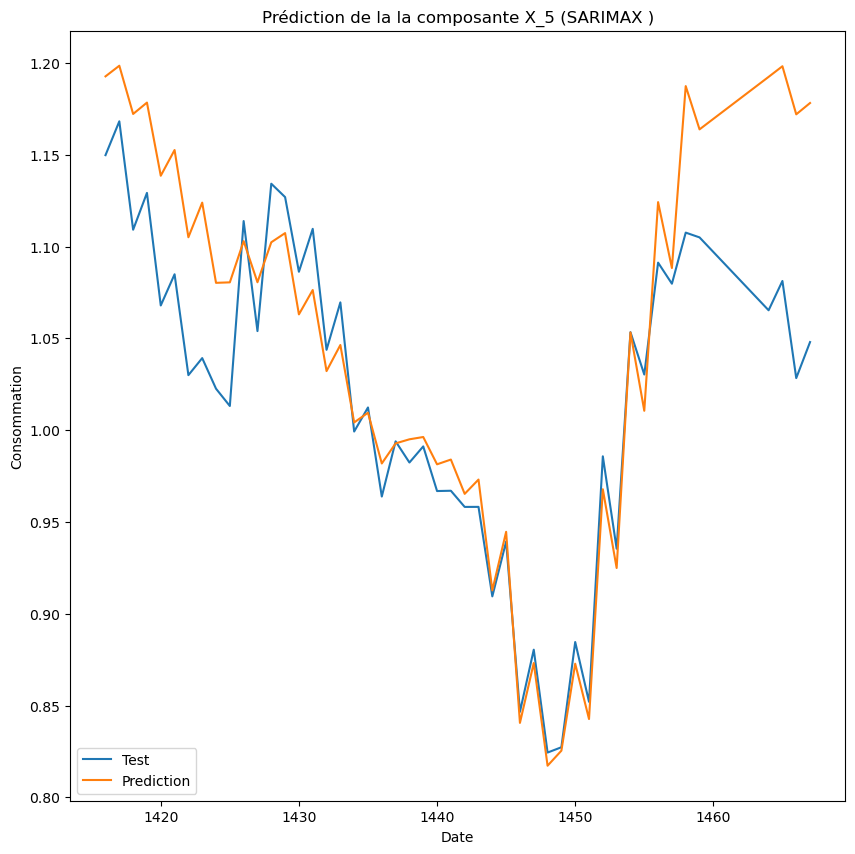

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(X_5_test, label ='Test')
plt.plot(X_5_prediction, label ="Prediction")
plt.title("Prédiction de la la composante X_5 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(X_5_test, X_5_prediction)
print(f"MAPE: {mape:.2%}")

MAPE: 3.33%


In [ ]:
from sklearn import preprocessing




import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Préparation des données
def scale_data(X_train_df, X_test_df):
    scaler = MinMaxScaler()
    if len(X_train_df.shape) == 1:
        X_train_scaled = scaler.fit_transform(X_train_df.values.reshape(-1, 1))
        X_test_scaled = scaler.transform(X_test_df.values.reshape(-1, 1))
    else:
        X_train_scaled = scaler.fit_transform(X_train_df)
        X_test_scaled = scaler.transform(X_test_df)
    return X_train_scaled, X_test_scaled, scaler

# 2. Création des séquences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    y = y.values if isinstance(y, pd.Series) else np.array(y)  # ⬅️ conversion en array
    for i in range(len(X) - window_size):
        X_seq = X[i:i+window_size]
        y_seq = y[i + window_size]
        if len(X_seq.shape) == 1:
            X_seq = X_seq.reshape(-1, 1)
        Xs.append(X_seq)
        ys.append(y_seq)
    return np.array(Xs), np.array(ys)





In [141]:
columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Total énergie soutirée (Wh)' : 'y'
}
df_out = sub_df[columns.keys()]
df_out = df_out.rename(columns = columns)
df_out.head()

,T,U,FF,R,y
1254162,12.718644,70.061538,6.384746,0.0,32457452.0
1254163,12.718644,70.061538,6.384746,0.0,33427025.0
1254164,12.565537,70.138462,6.335593,0.0,30720205.0
1254165,12.565537,70.138462,6.335593,0.0,31645442.0
1254166,12.475706,70.630769,6.381356,0.0,29879884.0


In [20]:
 # pour le résiduel ******************************
#*********************************************

import LstmModel
import importlib
# clear the import cache
importlib.reload(LstmModel)
# now you can import my_class and it'll be updated
from LstmModel import LSTMModel
test_long = 48 
# Préparation du DataFrame avec décomposition : on s'intéresse à la tendance
df = pd.DataFrame()
#sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 
columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Total énergie soutirée (Wh)' : 'y'
}

for cl in columns.keys():
    decomposer = DecompositionSerieTemporelle(colonne = cl, forme = 'multiplicative',periodes = [22,48,336])
    decomposer.fit(sub_df)
    df[columns[cl]] = decomposer.transform(sub_df).residuel
    #df[columns[cl]] = sub_df[cl]

df = df[[ 'y', 'T', 'R']].dropna().drop_duplicates()
df['nb'] = sub_df['Nb points soutirage']

df = df.dropna().drop_duplicates()

# Séparation des variables
X = df 
y = np.log(df['y']) 



X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = np.log(X['T'] - np.min(X['T']) + 1)
X['R'] = np.log(X['R'] - np.min(X['R']) + 1)




X_train =  X.iloc[:-test_long]
y_train =  y.iloc[:-test_long]
X_test  =  X.iloc[-test_long:]
y_test  =  y.iloc[-test_long:]


window_size = 7*48
# Extension du test
y_test_ext = pd.concat([y_train.iloc[-window_size:], y_test])

X_test_ext = pd.concat([X_train.iloc[-window_size:], X_test])

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test_ext)


X_train, y_train = create_sequences(X_train_scaled, y_train, window_size)

X_test, y_test = create_sequences(X_test_scaled,y_test_ext, window_size)


lstm = LSTMModel(window_size=window_size, n_neurons=128,  factor = 0.1, epochs=100, batch_size=32, nbfoldcv = 5, optimize_architecture=False, optimize_lr=False, use_grid_search=False)

print("Entraînement en cours...")
lstm.fit(X_train, y_train)

NameError: name 'DecompositionSerieTemporelle' is not defined

Prédictions...
Affichage des prédictions...


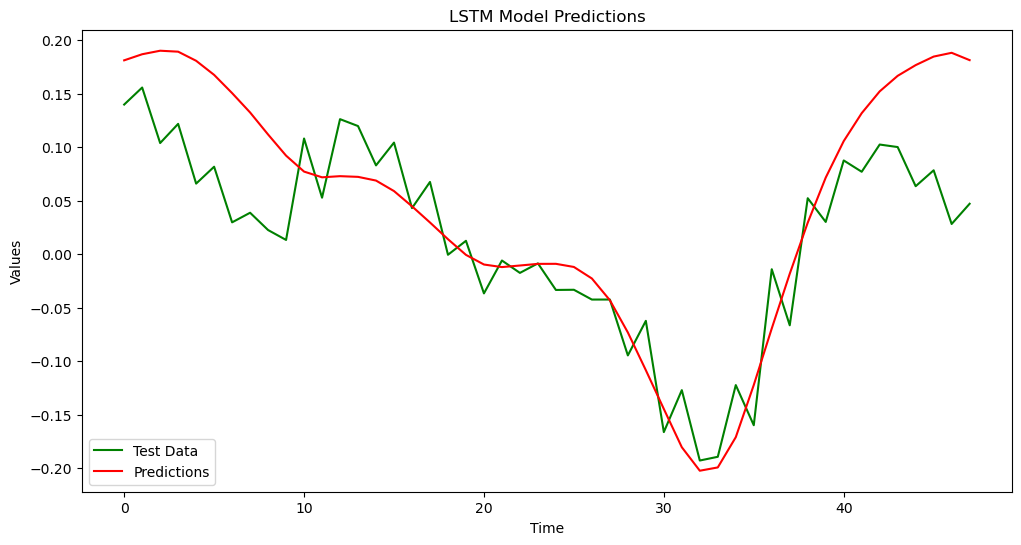

✅ MAE  = 0.05
✅ RMSE = 0.06
✅ MAPE = 153.23%


In [ ]:
import LstmModel
import importlib
# clear the import cache
importlib.reload(LstmModel)
# now you can import my_class and it'll be updated
from LstmModel import LSTMModel

print("Prédictions...")
predictions = lstm.predict(X_test)

print("Affichage des prédictions...")
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Test Data', color='green')
plt.plot(predictions, label='Predictions', color='red')
plt.title('LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

In [ ]:
import LstmModel
import importlib
# clear the import cache
importlib.reload(LstmModel)
# now you can import my_class and it'll be updated
from LstmModel import LSTMModel
test_long = 96 
# Préparation du DataFrame avec décomposition : on s'intéresse à la tendance
df = pd.DataFrame()
#sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 
columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Total énergie soutirée (Wh)' : 'y'
}

for cl in columns.keys():
    decomposer = DecompositionSerieTemporelle(colonne = cl, forme = 'multiplicative',periodes = [22,48,336])
    decomposer.fit(sub_df)
    df[columns[cl]] = decomposer.transform(sub_df).tendance
    #df[columns[cl]] = sub_df[cl]

df = df[[ 'y', 'T', 'R']].dropna().drop_duplicates()
df['nb'] = sub_df['Nb points soutirage']

df = df.dropna().drop_duplicates()

# Séparation des variables
X = df.drop(columns='y')
y = np.log(df['y']) 



X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = np.log(X['T'] - np.min(X['T']) + 1)
X['R'] = np.log(X['R'] - np.min(X['R']) + 1)




X_train =  X.iloc[:-test_long]
y_train =  y.iloc[:-test_long]
X_test  =  X.iloc[-test_long:]
y_test  =  y.iloc[-test_long:]






window_size = 48
# Extension du test
y_test_ext = pd.concat([y_train.iloc[-window_size:], y_test])

X_test_ext = pd.concat([X_train.iloc[-window_size:], X_test])

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test_ext)


X_train, y_train = create_sequences(X_train_scaled, y_train, window_size)

X_test, y_test = create_sequences(X_test_scaled,y_test_ext, window_size)


lstm = LSTMModel(window_size=window_size, n_neurons=128,  factor = 0.1, epochs=100, batch_size=32, nbfoldcv = 5, optimize_architecture=False, optimize_lr=False, use_grid_search=False)

print("Entraînement en cours...")
lstm.fit(X_train, y_train)

saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
Entraînement en cours...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 16.4735
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 12.3506
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.5799
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.2262
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.1800
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.1822
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.1594
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.1012
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0846
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.2307
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.1201
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.1197


LSTMModel(epochs=100, factor=0.1, n_neurons=128)

In [19]:
lstm

NameError: name 'lstm' is not defined

In [18]:
import LstmModel
import importlib
# clear the import cache
importlib.reload(LstmModel)
# now you can import my_class and it'll be updated
from LstmModel import LSTMModel

print("Prédictions...")
predictions = lstm.predict(X_test)

print("Affichage des prédictions...")
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Test Data', color='green')
plt.plot(predictions, label='Predictions', color='red')
plt.title('LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim([0,20])
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(np.exp(y_test), np.exp(predictions))
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

Prédictions...


NameError: name 'lstm' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

✅ MAE  = 17.79
✅ RMSE = 17.79
✅ MAPE = 99.84%


In [ ]:
# Visualisation pour X_2 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from SarimaxModels import SARIMAModel
# Prediction de X_2
import numpy as np 




X_2_train = X_2.iloc[len(X_2) - 7*test_long:len(X_2)-test_long]
X_2_test =  X_2.iloc[-test_long:]





print("modèle...")

sarima_conso = SARIMAX(X_2_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)



print("entrainement...")
sarima_conso.fit(X_2_train)
print(sarima_conso)
print("prediction...")
#forecast_X_2 = results_X_2.get_forecast(steps=len(X_2_test))
forecast_X_2 = sarima_conso.transform(X=X_2_test)
print("moyenne prediction ...")
X_2_prediction = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()

X_2_prediction = pd.Series(X_2_prediction, index = X_2_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_2_train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label='Prédiction X_2', color='red')
plt.fill_between(X_2_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_2_test, X_2_prediction)
print(f"MAPE: {mape:.2%}")

In [ ]:
X_3_train = X_5.iloc[:-test_long]
X_3_test =  X_5.iloc[-test_long:]
from pandas.tseries.frequencies import to_offset

# Creating Fourier Terms
def fourier_series(index, period, terms):
    t = np.arange(len(index))
    return np.column_stack([
        np.sin(2 * np.pi * t * i / period) for i in range(0, terms + 1)
    ] + [
        np.cos(2 * np.pi * t * i / period) for i in range(0, terms + 1)
    ])

# Generate Fourier terms for the seasonal period (336)
fourier_terms = fourier_series(X_3_train.index, period=22, terms=16)
#model = SARIMAX(X_3_train.values, exog=fourier_terms, order=(2, 1, 1))
model = SARIMAX(X_3_train.values,order=(2,1,2),
                      seasonal_order=(2,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

                      
result = model.fit(disp=False)
print("prediction...")
fourier_terms_test = fourier_series(X_3_test.index, period=48, terms=16)
forecast_X_3 = result.get_forecast(steps=len(X_3_test)) #,exog=fourier_terms_test)
print("moyenne prediction ...")
X_3_prediction = forecast_X_3.predicted_mean
print("IC...")
conf_int = forecast_X_3.conf_int()

X_3_prediction = pd.Series(X_3_prediction, index = X_3_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_3_train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_3_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_3_test, X_3_prediction)
print(f"MAPE: {mape:.2%}")

KeyboardInterrupt: 

In [ ]:
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
# Métriques
mae = mean_absolute_error(X_1_test, X_1_prediction)
rmse = np.sqrt(mean_squared_error(X_1_test, X_1_prediction))
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")




✅ MAE  = 0.00
✅ RMSE = 0.00
✅ MAPE = 0.00%


In [ ]:
# Prédiction de X_2 par NN regression
test_long = 192
# Packages 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import train_test_split

# Préparation du DataFrame avec décomposition : on s'intéresse à la tendance
df = pd.DataFrame()
#sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 
columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Total énergie soutirée (Wh)' : 'y'
}

for cl in columns.keys():
    decomposer = DecompositionSerieTemporelle(colonne = cl, forme = 'multiplicative',periodes = [22,48,336])
    decomposer.fit(sub_df)
    df[columns[cl]] = decomposer.transform(sub_df).tendance
    #df[columns[cl]] = sub_df[cl]




# Construction du timestamp 'ds' : peut être utile si on introduit des fct trigo pour la périodicité
#df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

# Garder uniquement les variables exogènes (regressors)
df = df[[ 'y', 'T', 'R']].dropna().drop_duplicates()




# Séparation des variables
X = df.drop(columns='y')
y = np.log(df['y']) 
df['nb'] = sub_df['Nb points soutirage']


X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = np.log(X['T']) # - np.min(X['T']) + 1)
X['R'] = np.log(X['R']) # - np.min(X['R']) + 1)
# Normalisation
from sklearn import preprocessing
minmax_scaler = preprocessing.MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)

"""

# séparation test & entrainement 
X_train = X_scaled[:-test_long]
X_test = X_scaled[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]




# Modèle DNN 
# Architecture 
# Couche d'entrée
dnn_model  = Sequential([Input(shape=(2,))])

# Couche 1 & 2  
dnn_model.add(Dense(units=128, activation="tanh")) 
dnn_model.add(Dense(units=64, activation="tanh"))

# Couche de sortie
dnn_model.add(Dense(units=1)) 
"""

# Modèle 2 

def create_sequences(df, window_size):
    #X, y = [], []
    X = []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :-1])
        #y.append(yin[i])  # Consommation comme cible
    return np.array(X)

window_size = 48  #  48 pas (24 heures  * 2 intervalle de 30 minutes)

X_scaled_sequenced = create_sequences(X_scaled,window_size)




# séparation test & entrainement 
X_train = X_scaled_sequenced[:-test_long]
X_test = X_scaled_sequenced[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]



dnn_model = Sequential([LSTM(64, input_shape =(X_scaled_sequenced.shape[1], X_scaled_sequenced.shape[2]), return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(units=64, activation="relu"),
        #Dense(units=8, activation="relu"),
        Dense(1)])

# Résumé du modèle
dnn_model.summary()



lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compilation du modèle

opt_1 = tf.optimizers.Adam(learning_rate=0.01)
dnn_model.compile(loss="mean_absolute_error",
             optimizer=opt_1,
             metrics=["mape"])

params = {'validation_split' : 0.2 , 'epochs' : 100, 'batch_size' : 32} 

dnn_history = dnn_model.fit(X_train, y_train,
         validation_split=params['validation_split'],
         epochs=params['epochs'], 
         batch_size=params['batch_size'],
         callbacks=[early_stopping, lr_scheduler])



# Prédiction
y_pred =  dnn_model.predict(X_test).flatten()
X_2_prediction_dnn = y_pred 






saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336
saisonnalite_22
saisonnalite_48
saisonnalite_336


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 23.3983 - mape: 139.1268 - val_loss: 0.0959 - val_mape: 0.5517 - learning_rate: 0.0100
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0941 - mape: 0.5579 - val_loss: 0.1256 - val_mape: 0.7239 - learning_rate: 0.0100
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1007 - mape: 0.5975 - val_loss: 0.1084 - val_mape: 0.6222 - learning_rate: 0.0100
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0858 - mape: 0.5088 - val_loss: 0.1028 - val_mape: 0.5907 - learning_rate: 0.0100
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0869 - mape: 0.5150 - val_loss: 0.1103 - val_mape: 0.6366 - learning_rate: 0.0100
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0904 - mape: 0.5358 - val_loss: 0.1713 - val_mape: 0.9839 - learning_rate: 0.0100
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0531 - mape: 0.3141 - val_loss: 0.0988 - val_mape: 0.5683

In [ ]:
#mape = mean_absolute_percentage_error(y_test, y_pred)
# Métriques
mae = mean_absolute_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long])
rmse = np.sqrt(mean_squared_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long]))
mape = mean_absolute_percentage_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long])

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")



✅ MAE  = 11.04
✅ RMSE = 11.24
✅ MAPE = 3.42%


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

✅ MAE  = 0.03
✅ RMSE = 0.03
✅ MAPE = 0.19%


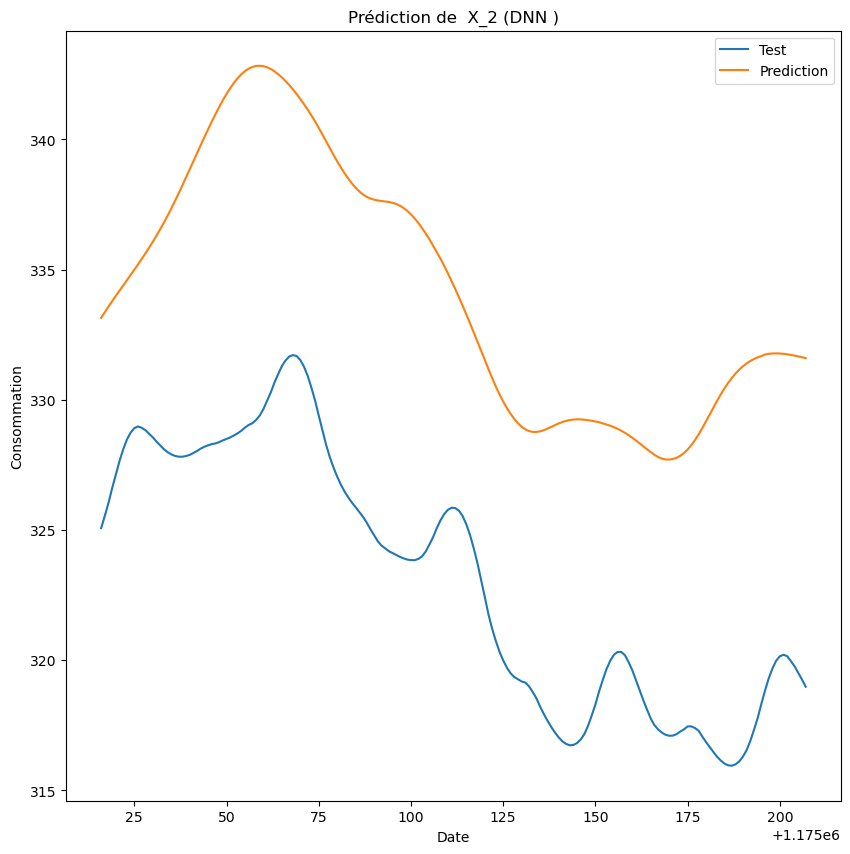

In [ ]:
# # Affichage pour X_2 prédit par DNN


# MAP pour X_2
plt.figure(figsize=(10,10))
plt.plot(np.exp(y_test.values)/df['nb'].iloc[forceast_long-test_long:forceast_long], label ='Test')
plt.plot(np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long], label ="Prediction")
#plt.plot((y_test.values-np.min(y_test.values))/(np.max(y_test.values)- np.min(y_test.values)), label ='Test')
#plt.plot((y_pred-np.min(y_pred))/(np.max(y_pred)- np.min(y_pred)), label ="Prediction")
#plt.plot(X_test[:,0], label = 'T')
#plt.plot(X_test[:,-1], label = 'R')
##plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de  X_2 (DNN )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

plt.show()

In [ ]:
sub_df['Profil'].unique()

array(['RES11 (+ RES11WE)'], dtype=object)

In [ ]:
sub_df.columns

Index(['Région', 'Code région', 'Profil', 'Plage de puissance souscrite',
       'Nb points soutirage', 'Total énergie soutirée (Wh)',
       'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
       'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
       'Courbe Moyenne n°1 + n°2 (Wh)',
       'Indice représentativité Courbe n°1 + n°2 (%)',
       'Jour max du mois (0/1)', 'Semaine max du mois (0/1)', 'AAAAMMJJHH',
       'T_moyenne', 'T_STD', 'T_min', 'T_q25', 'T_q50', 'T_q75', 'T_max',
       'T_skew', 'T_kurtosis', 'FF_moyenne', 'FF_STD', 'FF_min', 'FF_q25',
       'FF_q50', 'FF_q75', 'FF_max', 'U_moyenne', 'U_STD', 'U_min', 'U_q25',
       'U_q50', 'U_q75', 'U_max', 'date', 'year', 'month', 'month_n', 'day',
       'day_n', 'h', 'mn', 's', 'Rayonnement solaire global (W/m2)'],
      dtype='object')

In [ ]:
np.sort([2,1,4])

array([1, 2, 4])

[ 22  44  88 132 176]


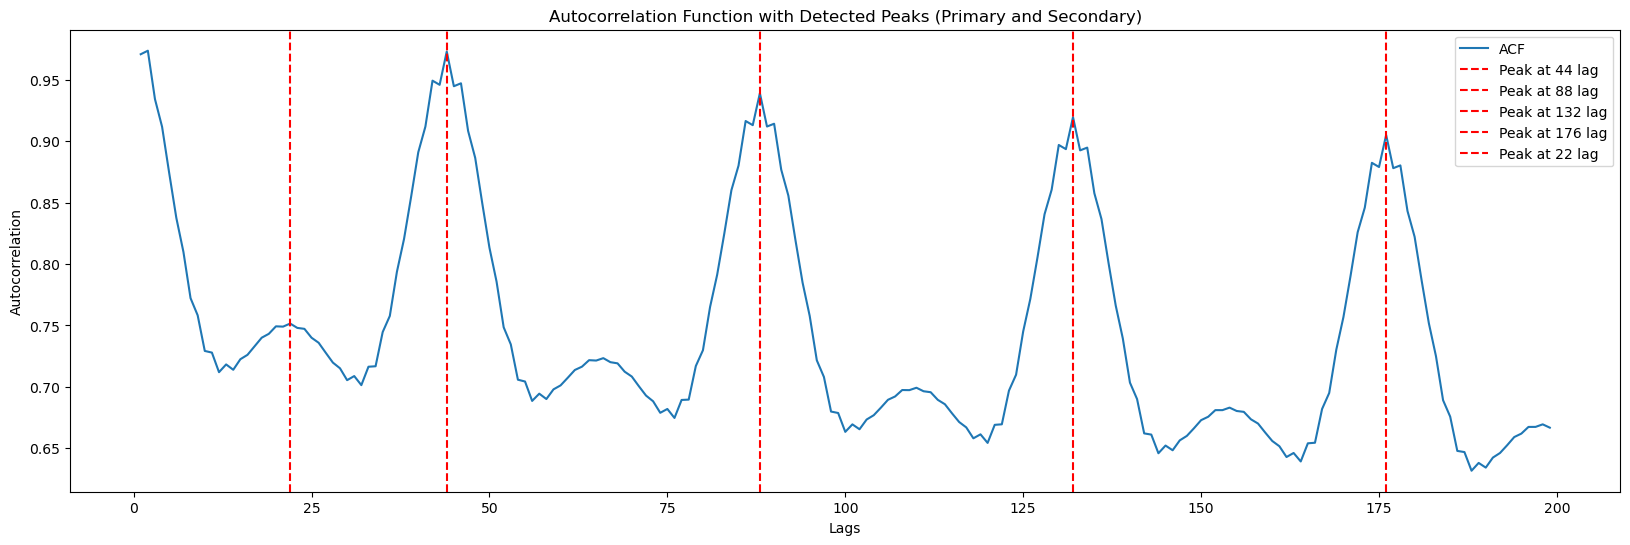

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import find_peaks

class ACFDominantFrequenciesOptimized(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, max_lag=500, height=0.01, distance=5, width=1, prominence=0.01):
        self.top_n = top_n
        self.max_lag = max_lag
        self.height = height
        self.distance = distance
        self.width = width
        self.prominence = prominence
        self.dominant_periods = None

    def fit(self, X, y=None):
        # Ensure the input is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError("Input must be a pandas Series.")

        # Compute Autocorrelation
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1  # To match the lag values

        # Detecting peaks (primary and secondary)
        peaks, properties = find_peaks(acf_values, height=self.height, distance=self.distance, width=self.width, prominence=self.prominence)

        # Sorting peaks by height and including small peaks
        peak_values = acf_values.iloc[peaks]
        self.dominant_periods = peak_values.nlargest(self.top_n).index

        return self

    def transform(self, X):
        if self.dominant_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return pd.DataFrame({
            'Dominant Periods (Lags)': self.dominant_periods
        })

    def plot_acf(self, X):
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1

        plt.figure(figsize=(20, 6))
        plt.plot(acf_values, label="ACF")

        # Highlighting the detected peaks
        for peak in self.dominant_periods:
            plt.axvline(x=peak, color='red', linestyle='--', label=f'Peak at {peak} lag')

        plt.title("Autocorrelation Function with Detected Peaks (Primary and Secondary)")
        plt.xlabel("Lags")
        plt.ylabel("Autocorrelation")
        plt.legend()
        plt.show()


# Example Usage
if __name__ == '__main__':
    # Load your data
    y = sub_df['Total énergie soutirée (Wh)']

    # Initialize and fit the extractor
    extractor = ACFDominantFrequenciesOptimized(
        top_n=5, 
        max_lag=200, 
        height=0.01, 
        distance=5, 
        width=1, 
        prominence=0.01
    )
    extractor.fit(y)

    # Display dominant periods (including small peaks)
    print(np.sort(extractor.transform(y)['Dominant Periods (Lags)']))

    # Plot the ACF with detected peaks (including small peaks)
    extractor.plot_acf(y)

    Top 1 Frequency  Top 2 Frequency  Top 3 Frequency  Top 4 Frequency  \
0               0.0              4.0              7.0             11.0   
1               0.0              4.0             42.0             81.0   
2               0.0              4.0             42.0             81.0   
3               0.0              4.0             81.0             42.0   
4               0.0              4.0             81.0             84.0   
..              ...              ...              ...              ...   
68              0.0              4.0              7.0             42.0   
69              0.0              4.0             81.0             42.0   
70              0.0              4.0             42.0             81.0   
71              0.0              4.0             42.0             39.0   
72              0.0              4.0              7.0             11.0   

    Top 5 Frequency  Top 6 Frequency  Top 7 Frequency  Top 8 Frequency  \
0              14.0             18.0 

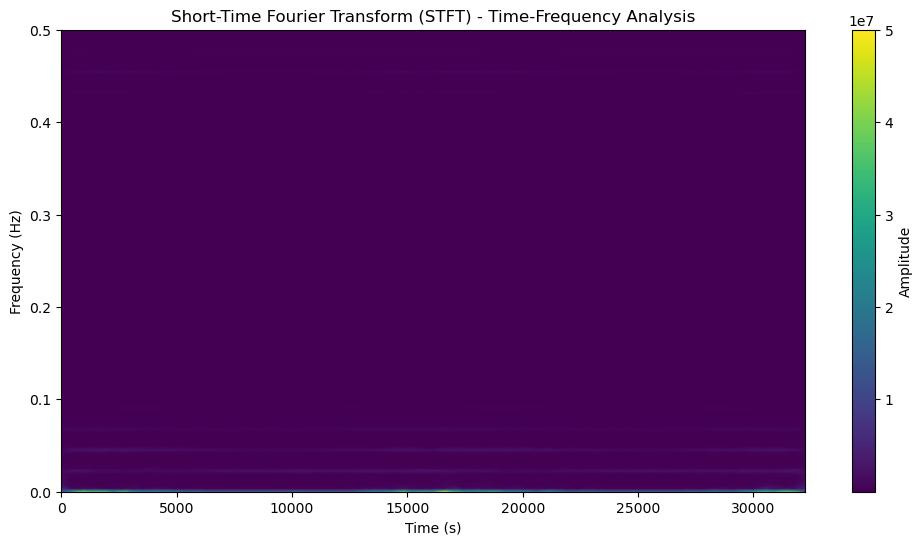

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import find_peaks

class ACFDominantFrequenciesOptimized(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, max_lag=500):
        self.top_n = top_n
        self.max_lag = max_lag
        self.height = None
        self.distance = None
        self.width = None
        self.prominence = None
        self.dominant_periods = None
        self.coherent_periods = None

    def fit(self, X, y=None):
        # Ensure the input is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError("Input must be a pandas Series.")

        # Compute Autocorrelation
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1  # To match the lag values

        # Adaptive height and prominence
        acf_mean = acf_values.mean()
        acf_std = acf_values.std()
        self.height = acf_mean + 0.1 * acf_std
        self.prominence = 0.05 * (acf_values.max() - acf_values.min())

        # Initial peak detection (large peaks)
        peaks, _ = find_peaks(acf_values, height=self.height, prominence=self.prominence)

        # Secondary peak detection (smaller peaks between primary)
        secondary_peaks, _ = find_peaks(acf_values, height=acf_mean, prominence=0.01 * acf_values.max(), distance=5)

        # Combine and sort all detected peaks
        all_peaks = np.unique(np.concatenate((peaks, secondary_peaks)))
        peak_values = acf_values.iloc[all_peaks]
        self.dominant_periods = peak_values.nlargest(self.top_n).index

        # Analyzing distances between peaks to find coherent periods
        periods = np.diff(self.dominant_periods)
        self.coherent_periods = pd.Series(periods).value_counts().nlargest(3).index.values

        return self

    def transform(self, X):
        if self.dominant_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return pd.DataFrame({
            'Dominant Periods (Lags)': self.dominant_periods,
            'Coherent Periods': [self.coherent_periods]
        })

    def plot_acf(self, X):
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1

        plt.figure(figsize=(12, 6))
        plt.plot(acf_values, label="ACF")

        # Highlighting the detected peaks
        for peak in self.dominant_periods:
            plt.axvline(x=peak, color='red', linestyle='--', label=f'Peak at {peak} lag')

        plt.title("Autocorrelation Function with Detected Peaks (Primary and Secondary)")
        plt.xlabel("Lags")
        plt.ylabel("Autocorrelation")
        plt.legend()
        plt.show()

    def get_coherent_periods(self):
        if self.coherent_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return self.coherent_periods

# Example Usage
if __name__ == '__main__':
    # Load your data
    y = sub_df['Total énergie soutirée (Wh)']
    # Initialize and fit the STFT extractor
    stft_extractor = STFTDominantFrequencies(window='hamming', nperseg=512, noverlap=64, top_n=15)
    stft_extractor.fit(y)

    # Display dominant frequencies over time
    print(np.round(1800*stft_extractor.transform(y)))

    # Plot the STFT
    stft_extractor.plot_stft(y)


In [ ]:

sub_def = df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)')]'P0: Total <= 36 kVA'
sub_def['Plage de puissance souscrite'].unique()
#df['Profil'].unique()

array(['P0: Total <= 36 kVA'], dtype=object)

In [ ]:
import DecompositionSerieTemporelle 
import AnalyseSpectrale 

# pour la mise à jour
import importlib
importlib.reload(DecompositionSerieTemporelle)
importlib.reload(AnalyseSpectrale)
from AnalyseSpectrale import SpectrogramAnalysis
# Exemple d'utilisation
#sub_def = df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)') & (df['Plage de puissance souscrite']=='P0: Total <= 36 kVA')]
    # Charger votre série temporelle
yy =  sub_df['y']
y_decompose   = seasonal_decompose(yy, period=14, model='multiplicative', extrapolate_trend='freq')
# Initialiser et ajuster l'analyse du spectrogramme
spectrogram_analyzer = SpectrogramAnalysis(window='hann', nperseg=56*48, noverlap=48, fs= 1/1800, threshold=0.1)
                                           
spectrogram_analyzer.fit(yy)#y_decompose.resid)
TT = spectrogram_analyzer.transform(yy)#y_decompose.resid)
print(TT)
spectrogram_analyzer.plot_spectrogramme()
    # Transformer pour obtenir les fréquences dominantes

print("Fréquences des raies spectrales (X pas de 30 minutes) :", TT)


In [389]:

import DecompositionSerieTemporelle 
import AnalyseSpectrale 
import PipelineAnalyseSpectraleDecomposition 
import SpectrogramToSARIMA
import SarimaxModels
import LstmModel



# pour la mise à jour
import importlib
importlib.reload(DecompositionSerieTemporelle)
importlib.reload(AnalyseSpectrale)
importlib.reload(PipelineAnalyseSpectraleDecomposition)
importlib.reload(LstmModel)
importlib.reload(SarimaxModels)
importlib.reload(SpectrogramToSARIMA)


from DecompositionSerieTemporelle import DecompositionSerieTemporelle
from AnalyseSpectrale import SpectrogramAnalysis
from SarimaxModels import SARIMAModel
from LstmModel import LSTMModel
from PipelineAnalyseSpectraleDecomposition import SpectroDecompPipeline
from SpectrogramToSARIMA import SpectrogramToSARIMAPipeline

spectro_params= {"fs": 1/1800, 
                 "window": "hann", 
                 "nperseg": 56*48, 
                 "noverlap": 48, 
                 "threshold": 0.5} # Un seuil plus élévé pour ne garder qu'une période
sarima_params= {"research_best_model": False}

def constructeur_pipeline_composante(df, colonne):
    # Initialiser et ajuster l'analyse du spectrogramme
    spectrogram_analyzer = SpectrogramAnalysis(window='hann', nperseg=56*48, noverlap=48, fs= 1/1800, threshold=0.1)
    yy = df[colonne]

    spectrogram_analyzer.fit(yy)
    periodes = spectrogram_analyzer.transform(yy) #y_decompose.resid)
    print(periodes)
    analyse_et_model_composante_saisonnalites = {} # Pipeline pour les différentes composantes de saisonnalités
    for periode in periodes['Périodes'] :  
        nom = f"pipeline_composante_saisonnalites_{int(periode)}"
        analyse_et_model_composante_saisonnalites[nom]  = SpectrogramToSARIMAPipeline(spectro_params=spectro_params,sarima_params=sarima_params)
    analyse_et_model_composante_saisonnalites["pipeline_composante_residuel"]  = SpectrogramToSARIMAPipeline(spectro_params=spectro_params,sarima_params=sarima_params)
    return analyse_et_model_composante_saisonnalites

pipeline = constructeur_pipeline_composante(sub_df, 'y')

   Périodes
0      14.0
1      22.0
2      44.0


In [390]:
pipeline

{'pipeline_composante_saisonnalites_14': SpectrogramToSARIMAPipeline(sarima_params={'research_best_model': False},
                             spectro_params={'fs': 0.0005555555555555556,
                                             'noverlap': 48, 'nperseg': 2688,
                                             'threshold': 0.5,
                                             'window': 'hann'}),
 'pipeline_composante_saisonnalites_22': SpectrogramToSARIMAPipeline(sarima_params={'research_best_model': False},
                             spectro_params={'fs': 0.0005555555555555556,
                                             'noverlap': 48, 'nperseg': 2688,
                                             'threshold': 0.5,
                                             'window': 'hann'}),
 'pipeline_composante_saisonnalites_44': SpectrogramToSARIMAPipeline(sarima_params={'research_best_model': False},
                             spectro_params={'fs': 0.0005555555555555556,
                     